### Install packages

`!pip install pandas
!pip install numpy 
!pip install matplotlib
!pip install seaborn`

In [1]:
### Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
### Access MySQL Server
import getpass
from functions import connect_mysql, mysql_list

# Input User id
try:
    # password input hashed
    id = getpass.getpass("id: ") 
except Exception as ex:
    print('Error Occured : ', ex)
#Input password
try:
    # password input hashed
    pwd = getpass.getpass("password: ") 
except Exception as ex:
    print('Error Occured : ', ex)

#host for RDS connection
host = "mdsi-dsp-spr-2020.cehiwpryiego.ap-southeast-2.rds.amazonaws.com"
mydb = connect_mysql(host, id, pwd)

if mydb: 
    print("Connection Successful")

id: ········
password: ········
Connection Successful


In [3]:
from functions import mysql_list
mydb = connect_mysql(host, id, pwd)
mycursor = mydb.cursor()
mycursor.execute("SHOW DATABASES;")
# create a list of database
db_list = mysql_list(mycursor.fetchall())
print(db_list) 
# asx is the database to be used
db = "asx"

['asx', 'information_schema', 'mysql', 'performance_schema']


In [4]:
mydb = connect_mysql(host, id, pwd, db)
mycursor = mydb.cursor()
mycursor.execute("SHOW TABLES;")
tb_list = mysql_list(mycursor.fetchall())
print(tb_list)

['ASX200_index', 'GDP_history_year', 'asx200', 'asx200_June_2020', 'asx200_month', 'asx_all', 'asx_history', 'asx_s_and_p', 'australia_GDP_1960_2020_usd', 'cashrate', 'exchange_rate', 'national_net_lending', 'net_lending_borrowing', 'new_loan_commitment_value_properties_purchased', 's_and_p', 'unemployment_rate', 'vix']


In [5]:
from IPython.display import display, HTML
mydb = connect_mysql(host, id, pwd, db)

for tb in tb_list:
    df = pd.read_sql_query("SELECT * FROM %s" % (tb), con=mydb)
    print(tb)
mydb.close()

ASX200_index
GDP_history_year
asx200
asx200_June_2020
asx200_month
asx_all
asx_history
asx_s_and_p
australia_GDP_1960_2020_usd
cashrate
exchange_rate
national_net_lending
net_lending_borrowing
new_loan_commitment_value_properties_purchased
s_and_p
unemployment_rate
vix


In [6]:
### Generate dataset from MySQL Server and rename as `gdp_per_cap`
mydb = connect_mysql(host, id, pwd, db)
gdp_per_cap = round(pd.read_sql_query("SELECT Year, GDP_per_cap FROM GDP_history_year", con=mydb),2)
gdp_per_cap.head()
gdp_per_cap.tail()

,Year,GDP_per_cap
45,2016-01-01,49971.13
46,2017-01-01,54066.47
47,2018-01-01,57395.92
48,2019-01-01,54907.10
49,2020-01-01,0.00


In [7]:
### Remove the last record as it is "0"
gdp_per_cap.drop(gdp_per_cap.tail(1).index,inplace=True)
gdp_per_cap.tail()

,Year,GDP_per_cap
44,2015-01-01,56755.72
45,2016-01-01,49971.13
46,2017-01-01,54066.47
47,2018-01-01,57395.92
48,2019-01-01,54907.10


In [8]:
### Add a column to show the annual difference
year1 = gdp_per_cap[['GDP_per_cap']].shift(1)

year2 = gdp_per_cap[['GDP_per_cap']]

gdp_per_cap[['GDP_Growth_in_dollars']] = year2 - year1

gdp_per_cap.head()
gdp_per_cap.tail()

,Year,GDP_per_cap,GDP_Growth_in_dollars
44,2015-01-01,56755.72,-5755.07
45,2016-01-01,49971.13,-6784.59
46,2017-01-01,54066.47,4095.34
47,2018-01-01,57395.92,3329.45
48,2019-01-01,54907.10,-2488.82


In [9]:
# Convert data type of 'date' column to date.
gdp_per_cap['Year'] = pd.to_datetime(gdp_per_cap['Year'], format = '%Y-%m-%d')

# Briefly check dataset
gdp_per_cap.info()
gdp_per_cap.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Year                   49 non-null     datetime64[ns]
 1   GDP_per_cap            49 non-null     float64       
 2   GDP_Growth_in_dollars  48 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 KB


,GDP_per_cap,GDP_Growth_in_dollars
count,49.000000,48.000000
mean,26270.548571,1071.190625
std,19409.844637,3557.506828
min,3489.950000,-6829.300000
25%,11518.670000,-117.982500
50%,19490.860000,715.025000
75%,40960.050000,2362.712500
max,68150.110000,10495.700000


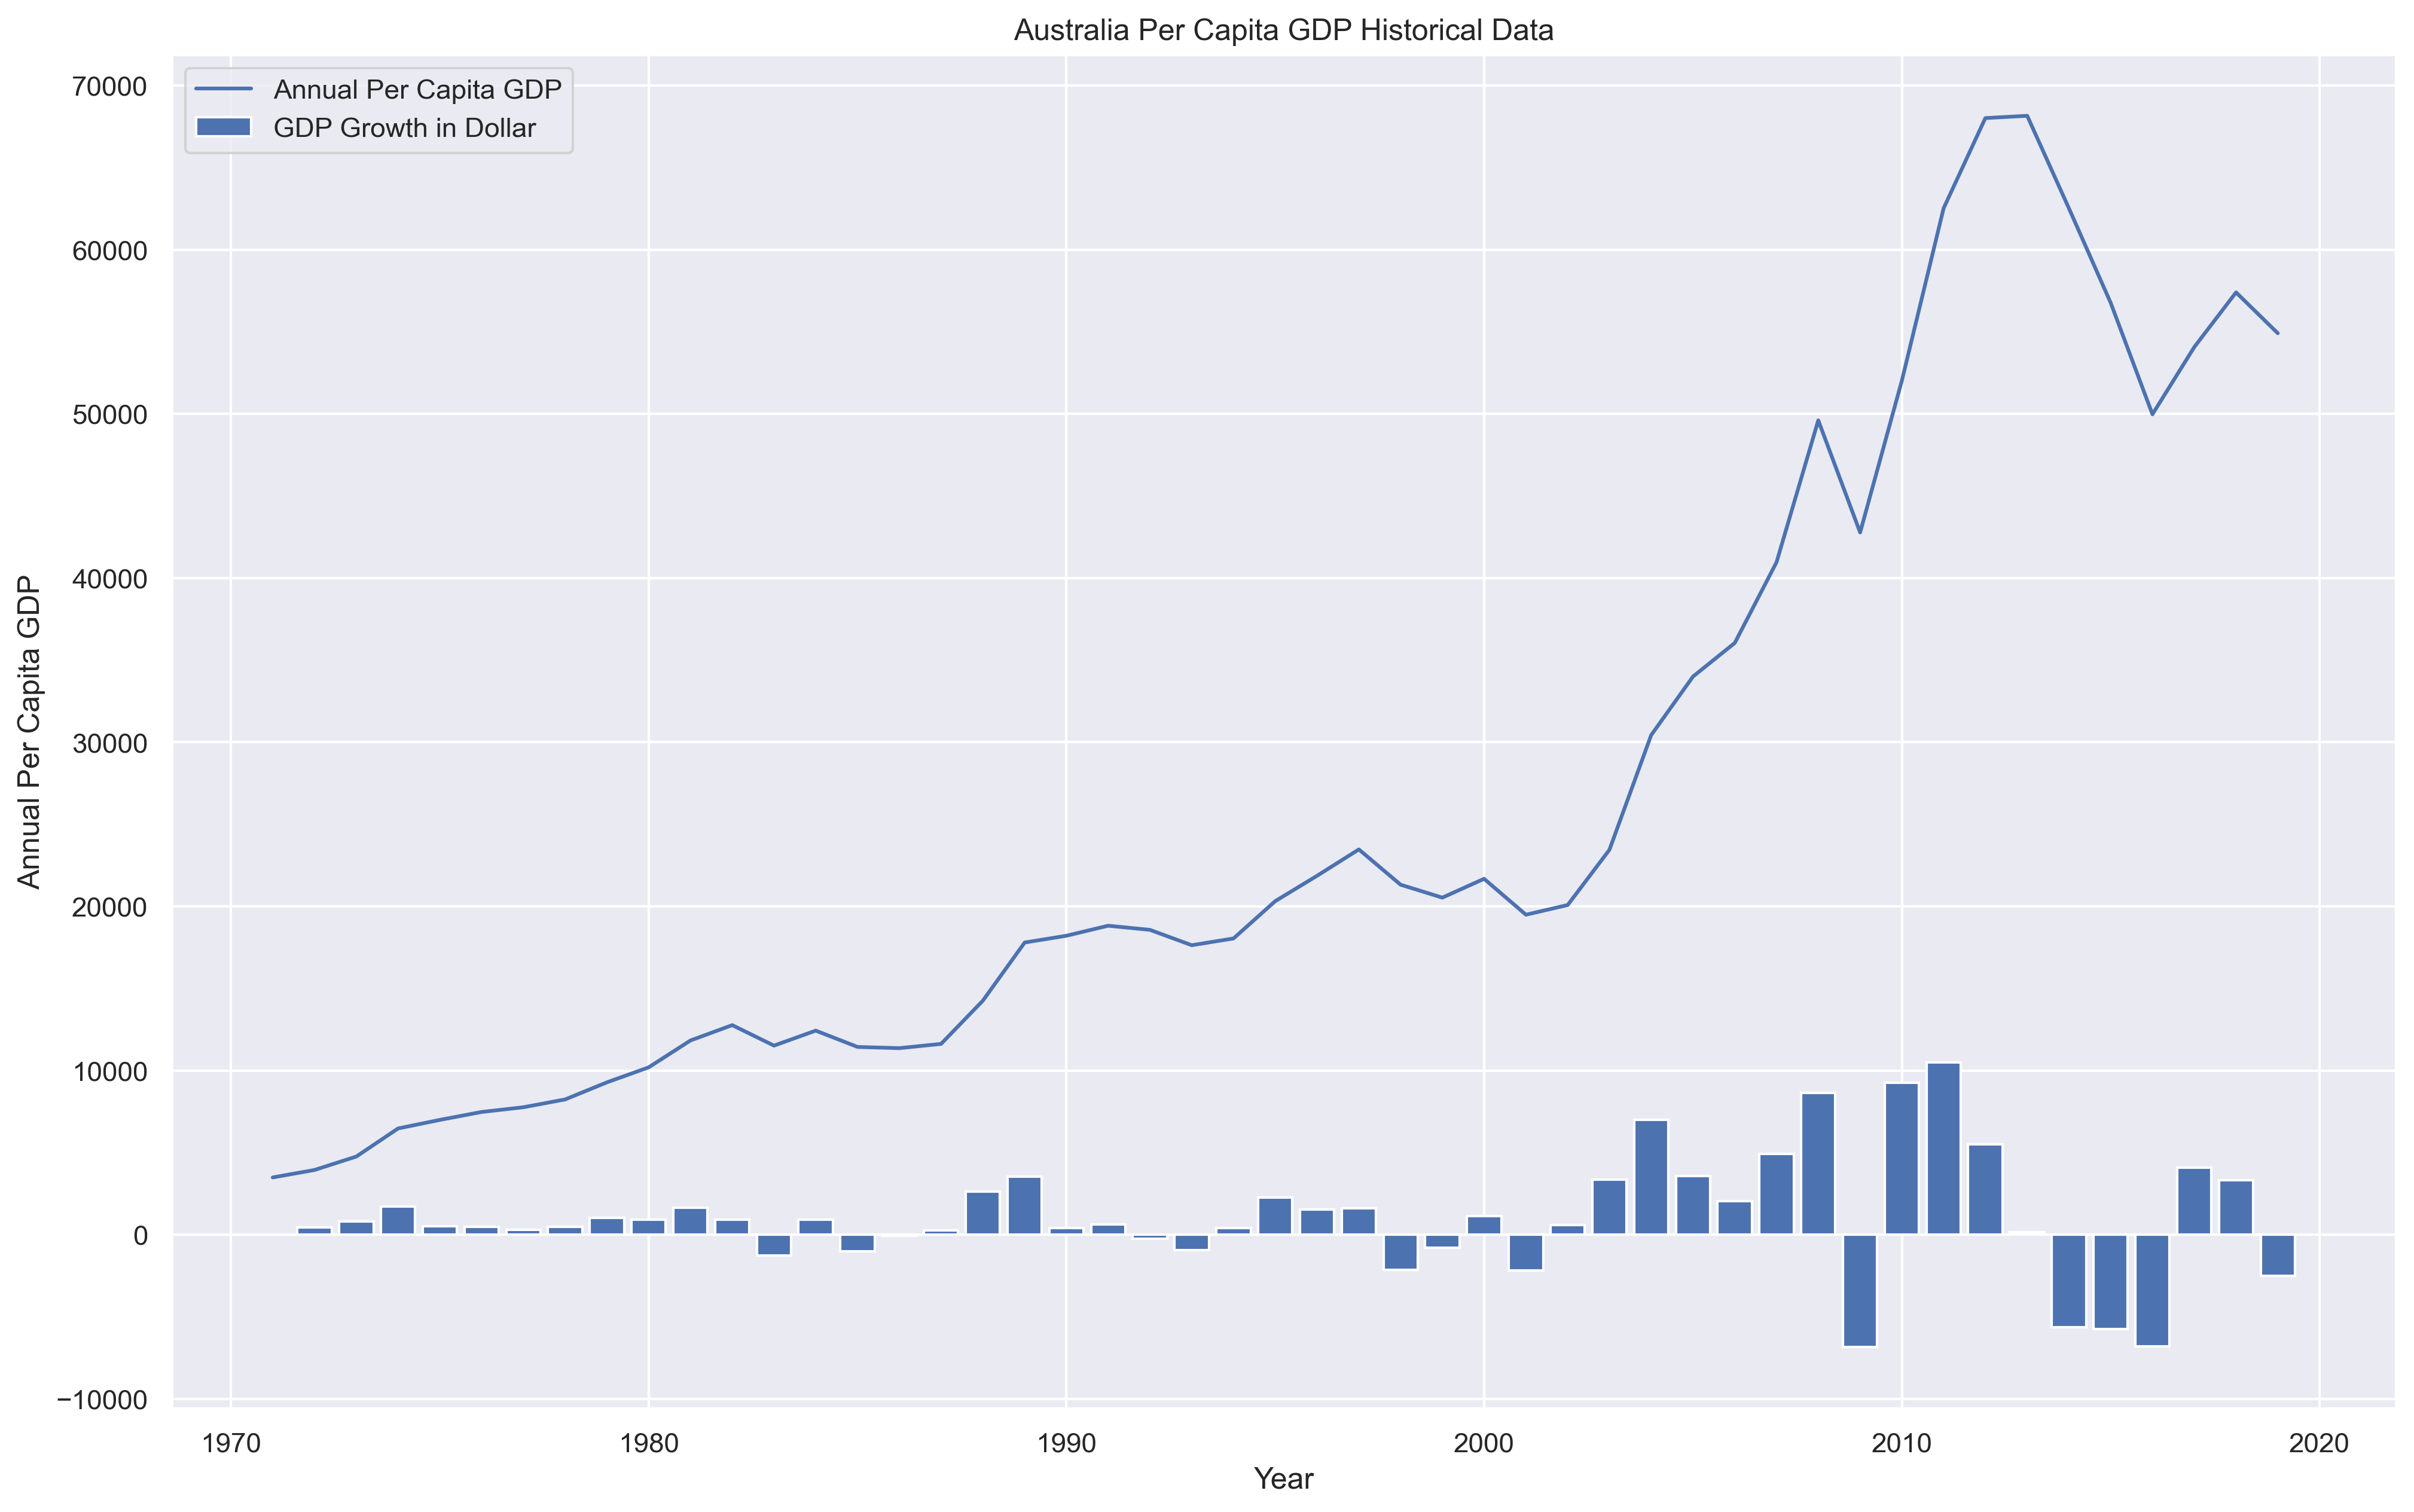

In [10]:
### Visualistion
gdp = gdp_per_cap['GDP_per_cap'].tolist()
diff = gdp_per_cap['GDP_Growth_in_dollars'].tolist()
year = gdp_per_cap['Year'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

plt.plot(year, gdp, label = "Annual Per Capita GDP")
plt.bar(year, diff, width=300, align = 'center', label = 'GDP Growth in Dollar')
plt.title('Australia Per Capita GDP Historical Data')
plt.xlabel('Year')
plt.ylabel('Annual Per Capita GDP')
plt.legend(loc="upper left")
plt.show()

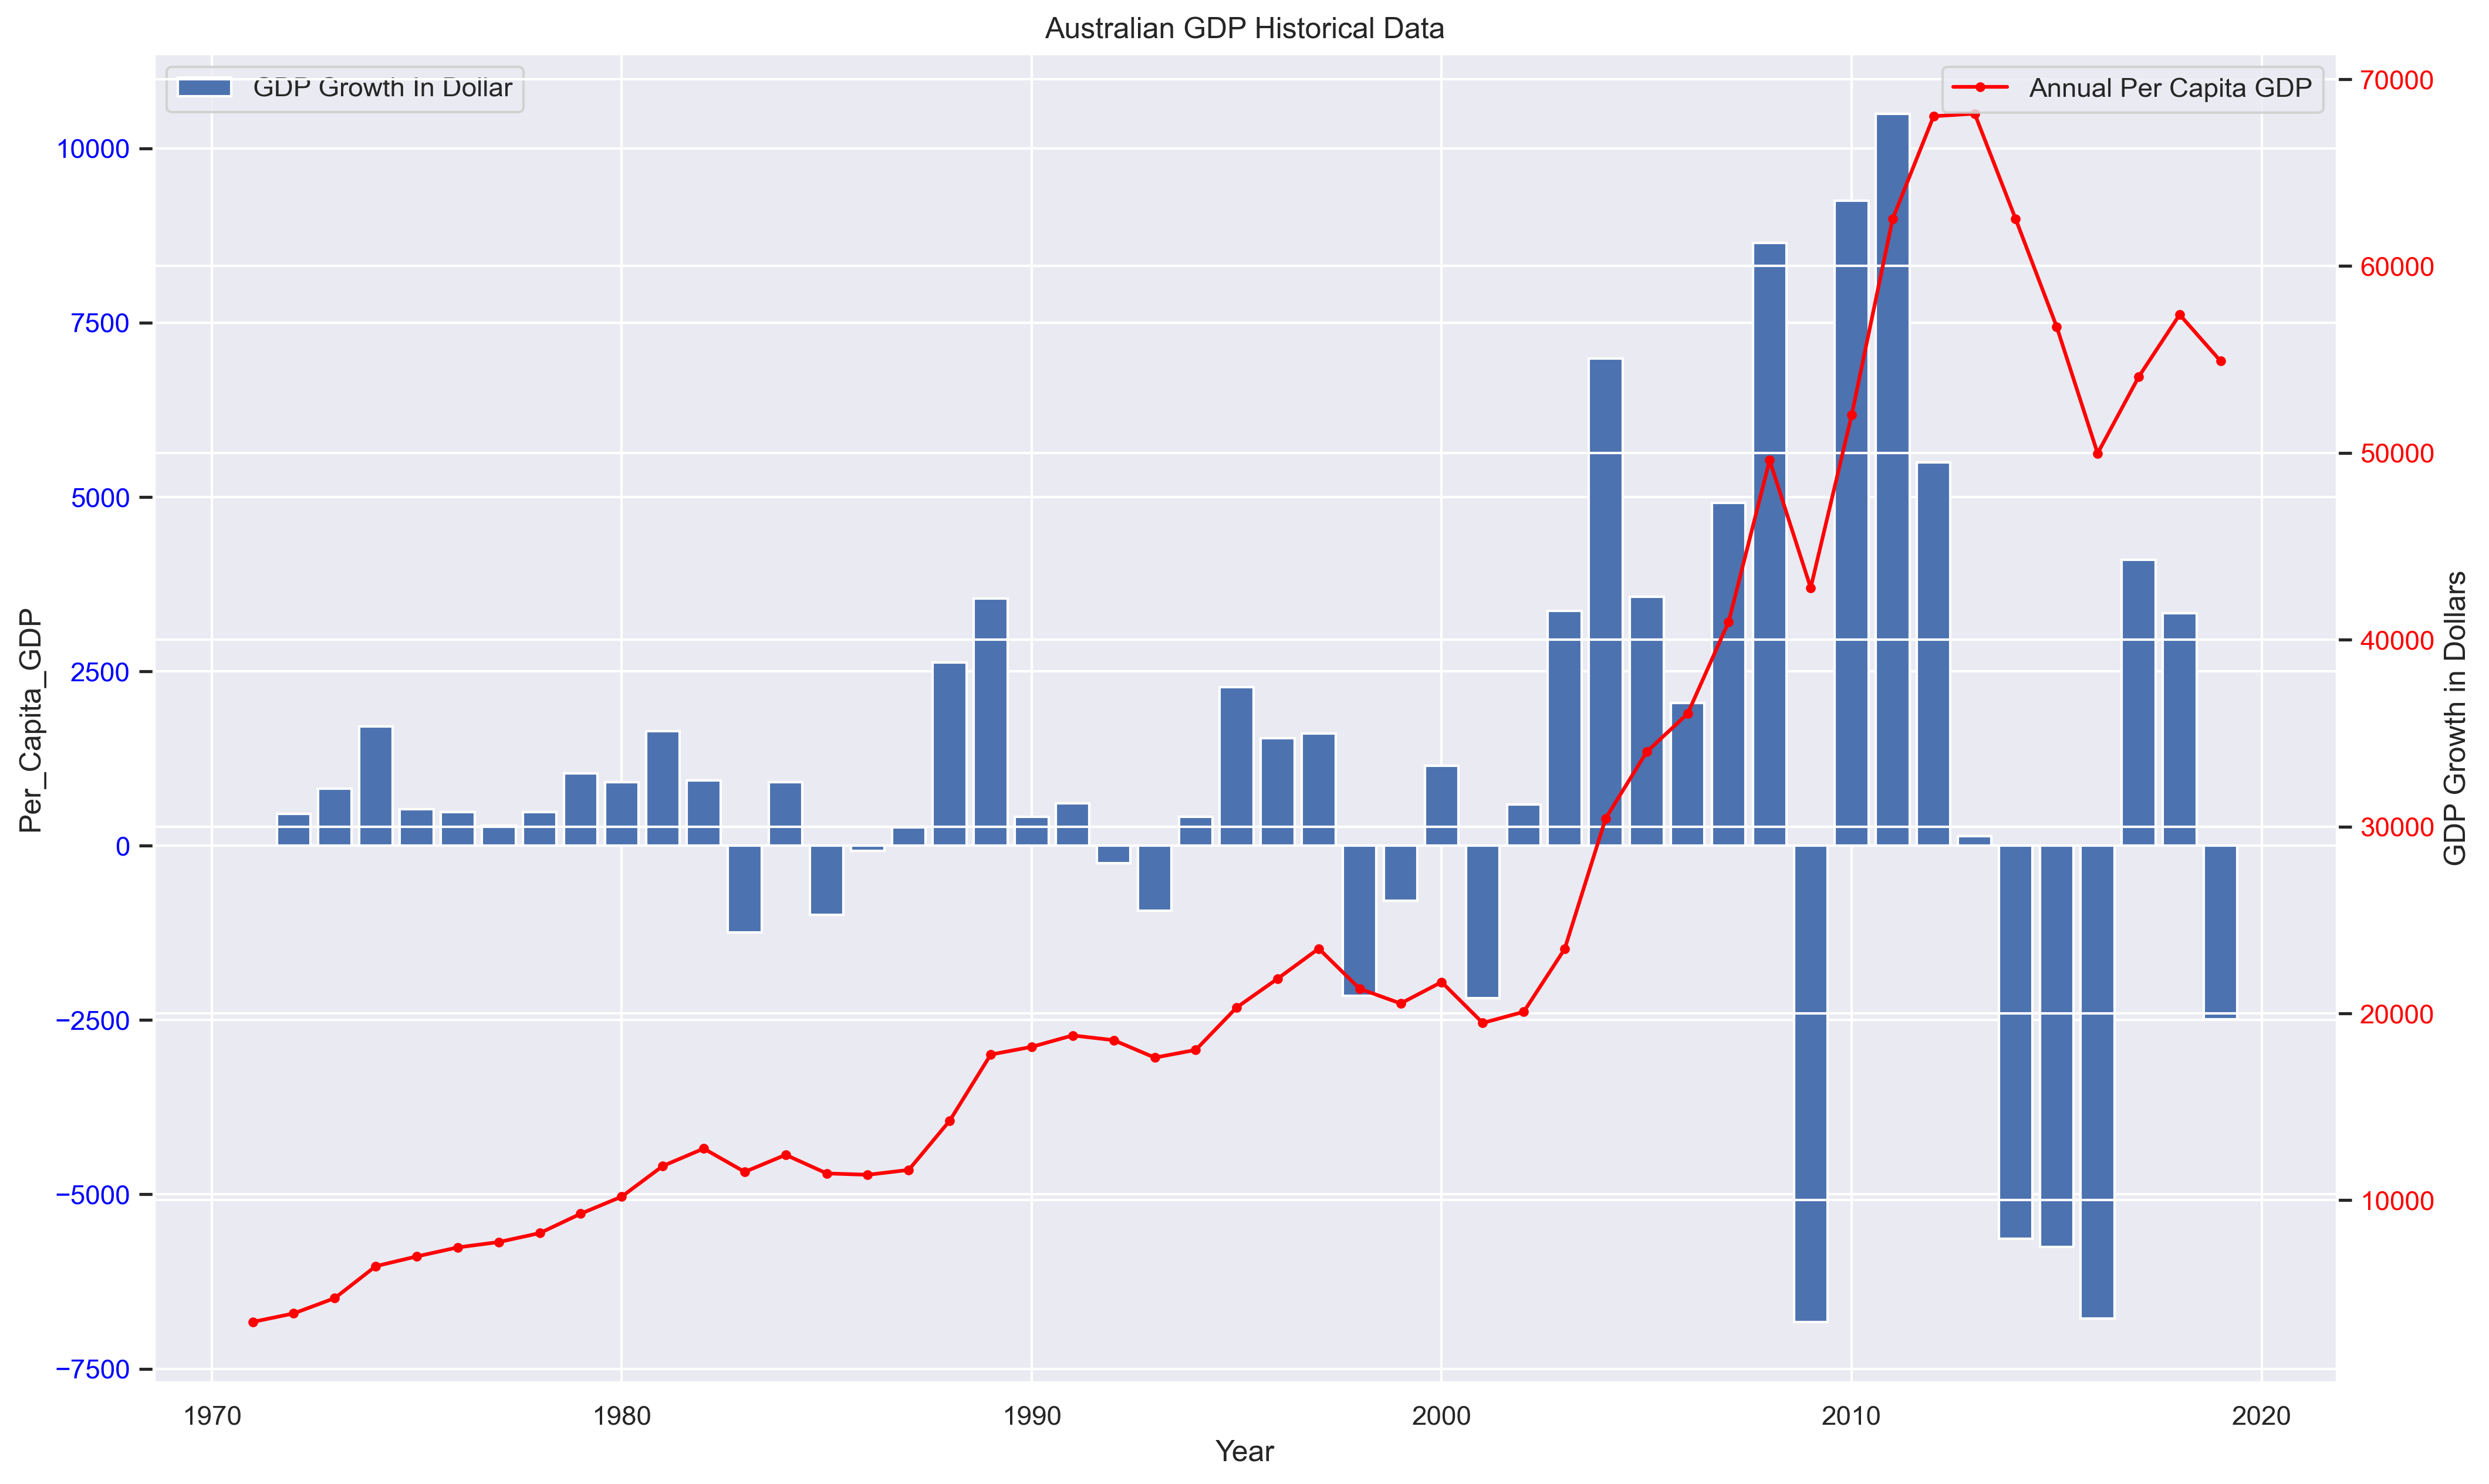

In [42]:
### Visualisation with two axes
gdp = gdp_per_cap['GDP_per_cap'].tolist()
diff = gdp_per_cap['GDP_Growth_in_dollars'].tolist()
year = gdp_per_cap['Year'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('Per_Capita_GDP')
lns1 = axes1.bar(year, diff, width=300, align = 'center', label = 'GDP Growth In Dollar')
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:blue'
axes2.set_ylabel('GDP Growth in Dollars')
lns2 = axes2.plot(year, gdp, marker = ".", color = "red", label = "Annual Per Capita GDP")
axes1.tick_params(axis='y', labelcolor="blue")
axes2.tick_params(axis='y', labelcolor="red")
axes2.legend(loc = "upper right")

plt.title('Australian GDP Historical Data')

plt.show()

Text(0.5, 1.0, 'Australian GDP Per Capita Historical Data')

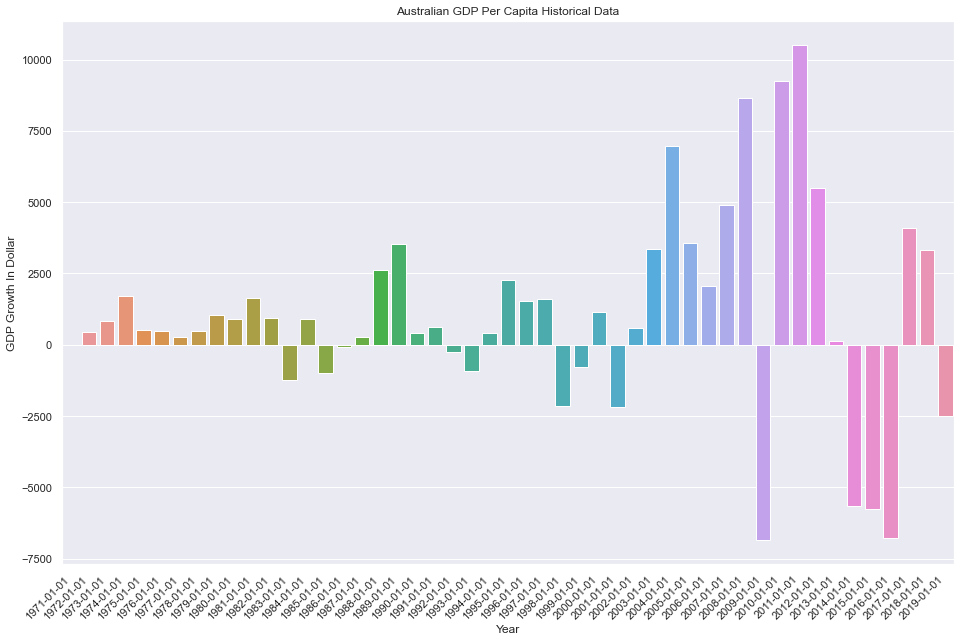

In [12]:
### Closer look at the annual differences
gdp = gdp_per_cap['GDP_per_cap'].tolist()
diff = gdp_per_cap['GDP_Growth_in_dollars'].tolist()
year = gdp_per_cap['Year'].tolist()

fig, ax = plt.subplots(figsize = (16,10))  

sns.barplot(x = year, y = diff)
x_dates = gdp_per_cap['Year'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel='Year', ylabel='GDP Growth In Dollar')
plt.title('Australian GDP Per Capita Historical Data')

In [13]:
#####  dgp per capita fell around 2009 (GFC), 2014 (aud dropped below 84 US cents), 2019 (economic growth slowed, per capita recession)

##### https://www.abc.net.au/news/2014-12-03/gross-domestic-product-gdp-data-abs-september-quarter/5936608?nw=0
##### https://www.businessinsider.com.au/australia-economy-q4-gdp-2019-3

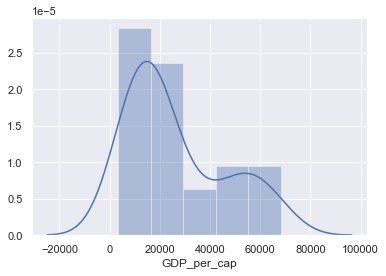

In [14]:
sns.distplot(gdp_per_cap['GDP_per_cap'])#?

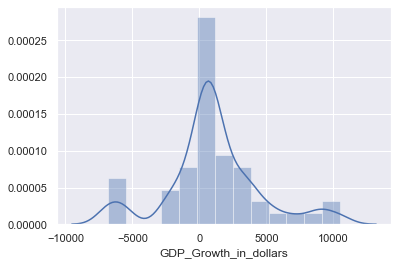

In [15]:
sns.distplot(gdp_per_cap['GDP_Growth_in_dollars'])#?

In [16]:
#  Generate dataset from MySQL Server and rename as `gdp_growth`
mydb = connect_mysql(host, id, pwd, db)
gdp_growth = pd.read_sql_query("SELECT Year, GDP_growth_perc FROM GDP_history_year", con=mydb)
gdp_growth.drop(gdp_growth.tail(1).index,inplace=True)

In [17]:
year3 = gdp_growth[['GDP_growth_perc']].shift(1)

year4 = gdp_growth[['GDP_growth_perc']]

gdp_growth[['yearly_difference']] = year4 - year3

gdp_growth.head()
gdp_growth.tail()

,Year,GDP_growth_perc,yearly_difference
44,2015-01-01,2.192640,-0.340475
45,2016-01-01,2.770657,0.578017
46,2017-01-01,2.367617,-0.403039
47,2018-01-01,2.940334,0.572716
48,2019-01-01,1.896826,-1.043508


In [18]:
# Convert data type of 'date' column to date.
gdp_growth['Year'] = pd.to_datetime(gdp_growth['Year'], format = '%Y-%m-%d')

# Briefly check dataset
gdp_growth.info()
gdp_growth.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Year               49 non-null     datetime64[ns]
 1   GDP_growth_perc    49 non-null     float64       
 2   yearly_difference  48 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 KB


,GDP_growth_perc,yearly_difference
count,49.000000,48.000000
mean,3.094365,-0.043894
std,1.422212,1.958069
min,-2.220458,-5.548859
25%,2.533115,-1.067753
50%,3.337959,-0.049237
75%,3.982695,0.703419
max,5.740729,6.801728


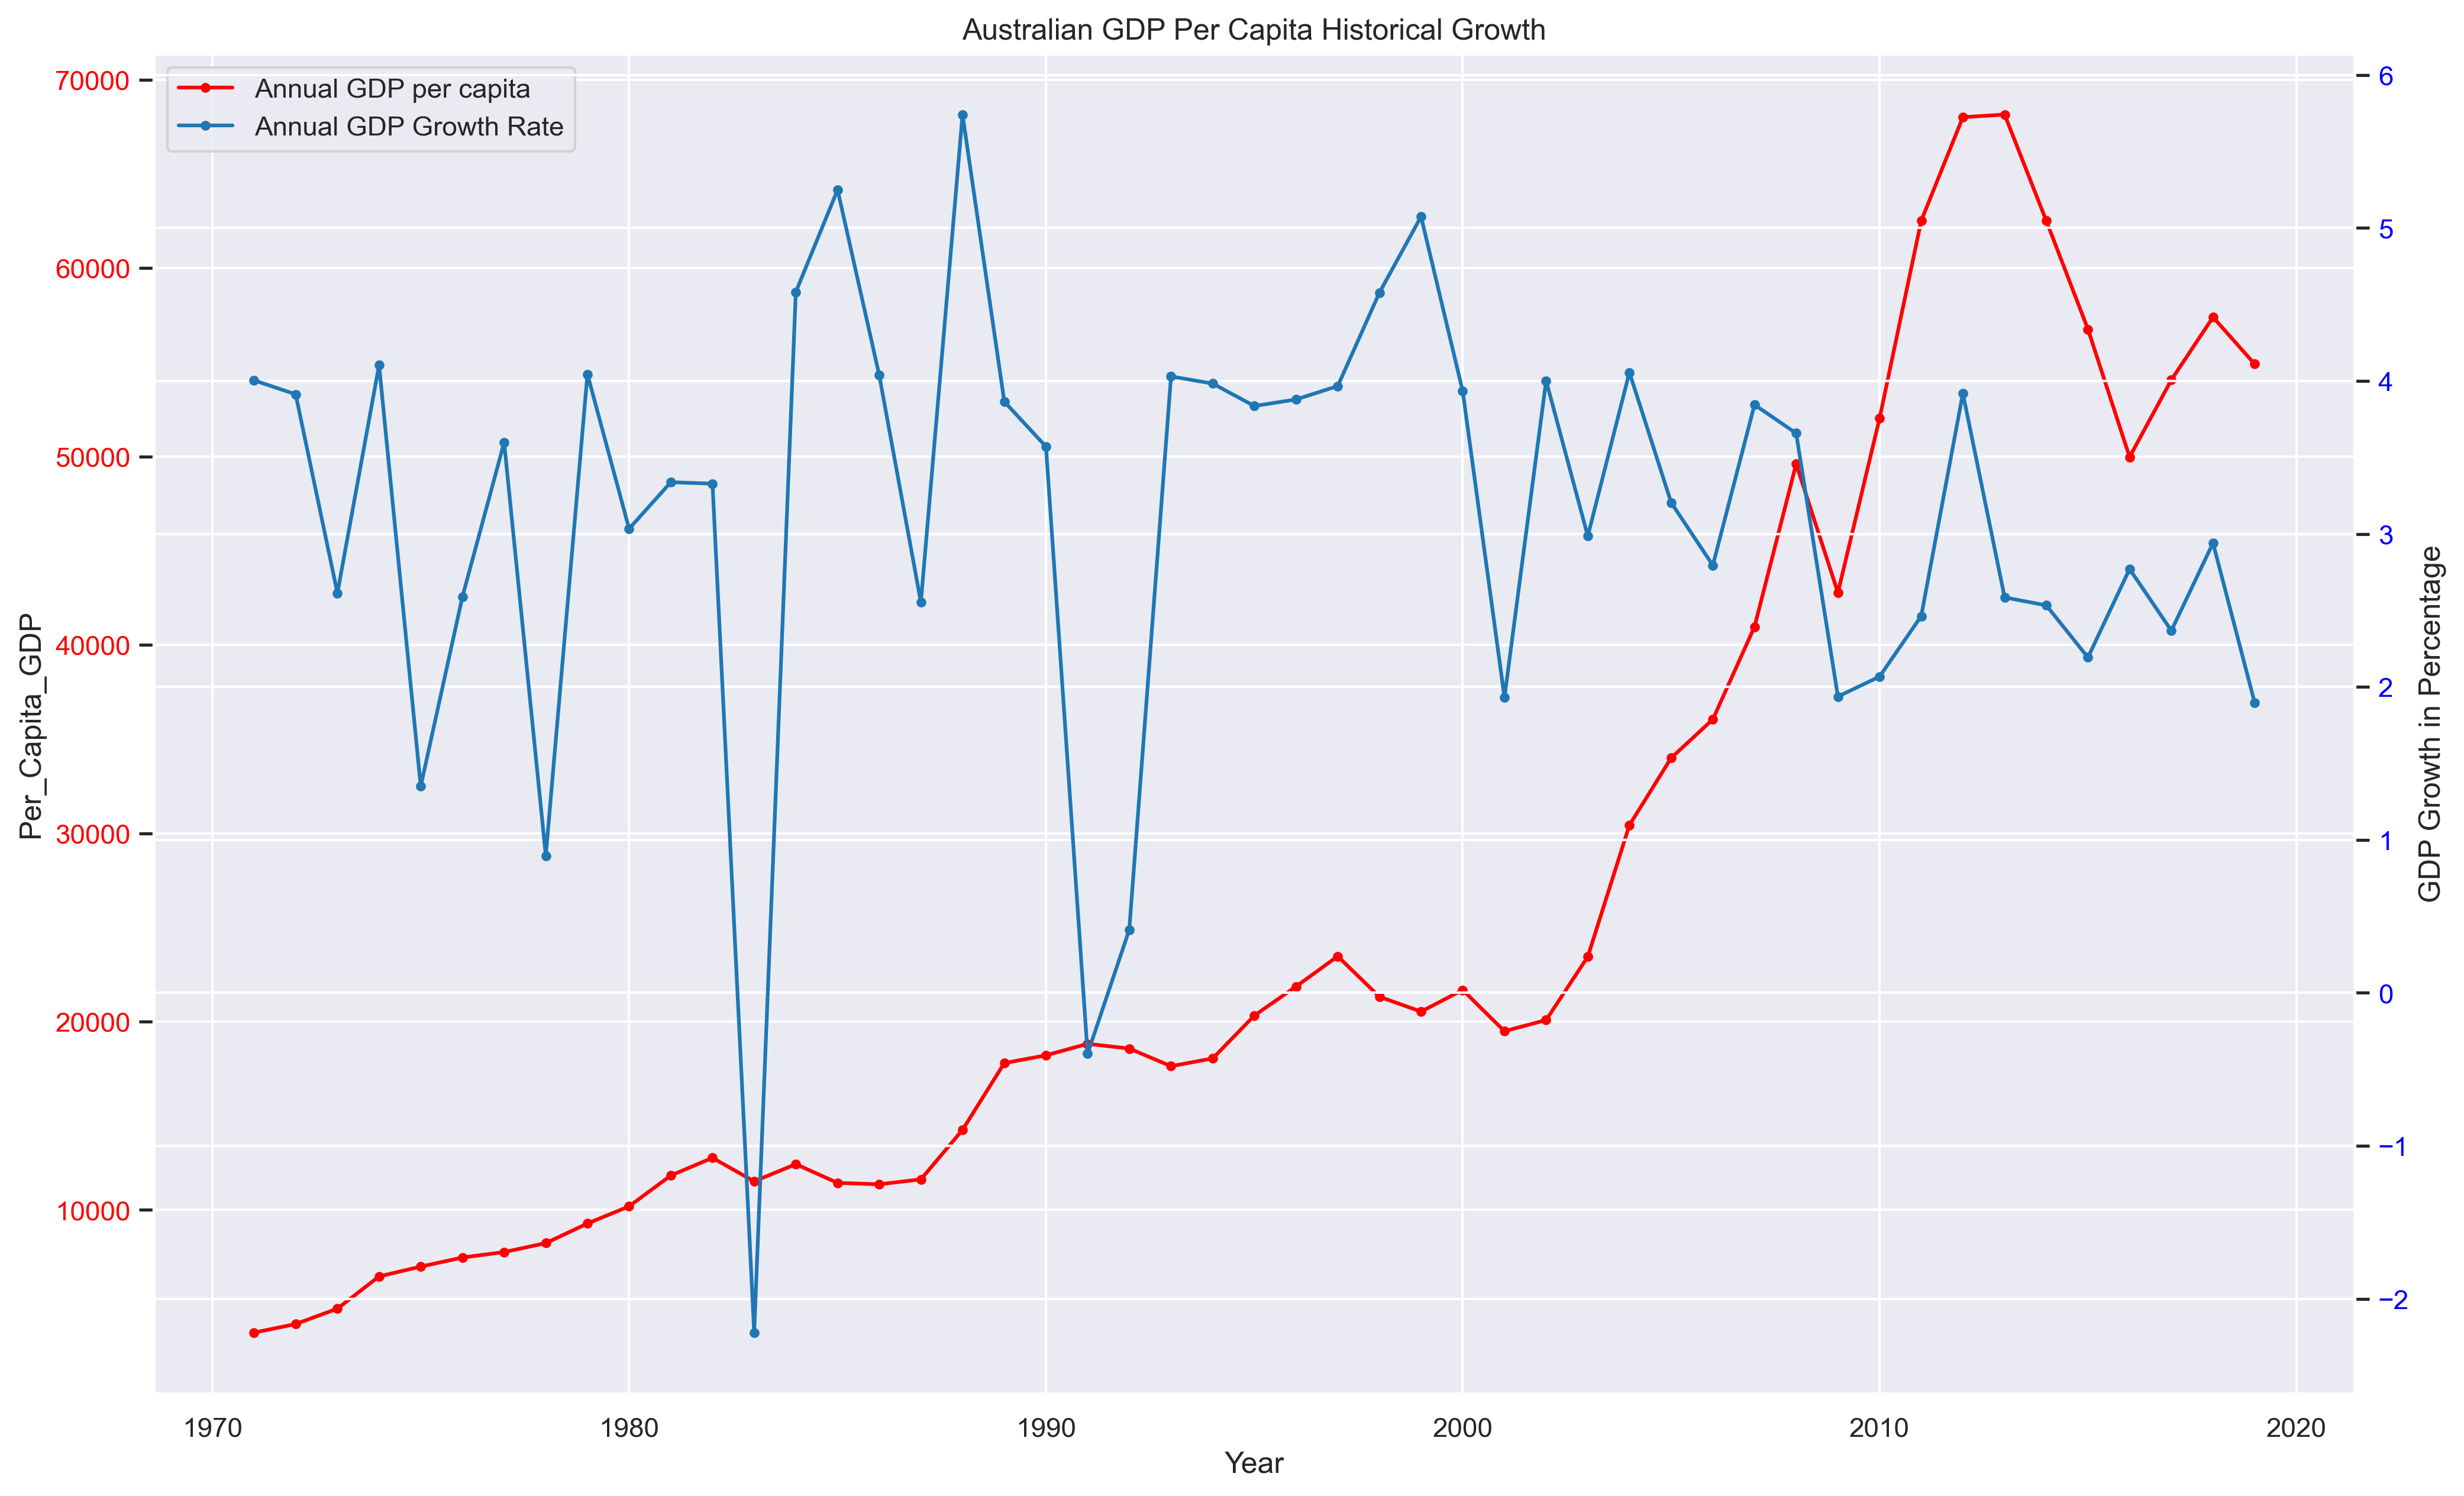

In [43]:
gdp = gdp_per_cap['GDP_per_cap'].tolist()
gdp_gro_rate = gdp_growth['GDP_growth_perc'].tolist()
year = gdp_growth['Year'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('Per_Capita_GDP')
lns1 = axes1.plot(year, gdp, marker = ".", color = "red", label = "Annual GDP per capita")
axes1.tick_params(axis='y', labelcolor="red")
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:blue'
axes2.set_ylabel('GDP Growth in Percentage')
lns2 = axes2.plot(year, gdp_gro_rate, marker = ".", color = color, label = 'Annual GDP Growth Rate')
axes2.tick_params(axis='y', labelcolor="blue")

plt.title('Australian GDP Per Capita Historical Growth')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
axes1.legend(lns, labs, loc="upper left")

plt.show()

Text(0.5, 1.0, 'Australian GDP Per Capita Annual Changes')

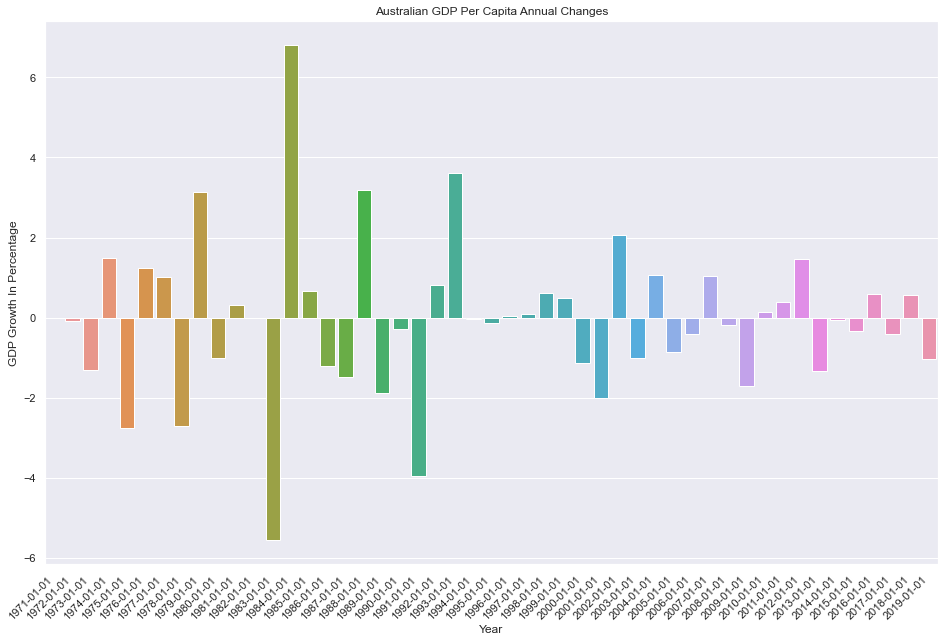

In [20]:
### Closer look at the annual differences
gdp_gro_rate = gdp_growth['GDP_growth_perc'].tolist()
year = gdp_growth['Year'].tolist()
diff = gdp_growth['yearly_difference'].tolist()

fig, ax = plt.subplots(figsize = (16,10))  

sns.barplot(x = year, y = diff)
x_dates = gdp_per_cap['Year'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel='Year', ylabel='GDP Growth In Percentage')
plt.title('Australian GDP Per Capita Annual Changes')

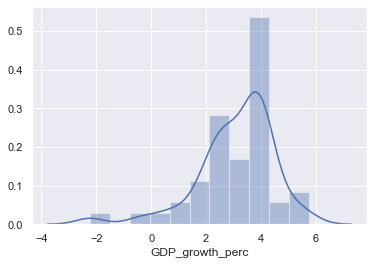

In [21]:
sns.distplot(gdp_growth['GDP_growth_perc'])#?

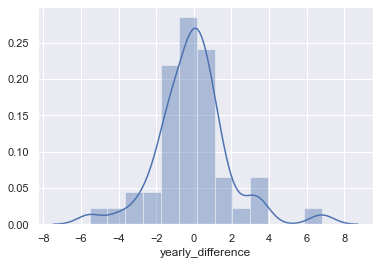

In [22]:
sns.distplot(gdp_growth['yearly_difference'])

In [62]:
#  Generate dataset from MySQL Server and rename as `house_commitment`
mydb = connect_mysql(host, id, pwd, db)
house_commitment = pd.read_sql_query("SELECT * FROM new_loan_commitment_value_properties_purchased", con=mydb)
house_commitment.head()


,Date,Total Commitment Value of Properties Purchased,Commitment Value of Owner Occupied Properties Purchased,Commitment Value of Investment Properties Purchased,Commitment Value from First Home Buyer
0,2002-07-01,10003.6,6025.1,3978.5,1466.2
1,2002-08-01,9981.6,5986.3,3995.3,1387.3
2,2002-09-01,10073.3,6036.9,4036.5,1327.4
3,2002-10-01,10236.2,6192.7,4043.5,1338.1
4,2002-11-01,10323.2,6259.7,4063.5,1307.5


In [63]:
# Convert data type of 'date' column to date. So that the dataframe could be ordered by date in the following steps. 
house_commitment['Date'] = pd.to_datetime(house_commitment['Date'], format = '%b-%y')

# Briefly check dataset
house_commitment.info()
house_commitment.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 5 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   Date                                                     217 non-null    datetime64[ns]
 1   Total Commitment Value of Properties Purchased           217 non-null    float64       
 2   Commitment Value of Owner Occupied Properties Purchased  217 non-null    float64       
 3   Commitment Value of Investment Properties Purchased      217 non-null    float64       
 4   Commitment Value from First Home Buyer                   217 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 8.6 KB


,Total Commitment Value of Properties Purchased,Commitment Value of Owner Occupied Properties Purchased,Commitment Value of Investment Properties Purchased,Commitment Value from First Home Buyer
count,217.000000,217.000000,217.000000,217.000000
mean,16472.625346,10433.730876,6038.895853,2555.579263
std,3165.341008,2188.967457,1383.491005,766.446345
min,9981.600000,5986.300000,3978.500000,1255.900000
25%,14080.000000,8874.800000,5052.200000,2214.500000
50%,16149.700000,10302.000000,5516.100000,2439.100000
75%,19361.600000,12099.900000,6717.500000,2763.100000
max,22644.900000,14517.000000,10054.600000,5197.200000


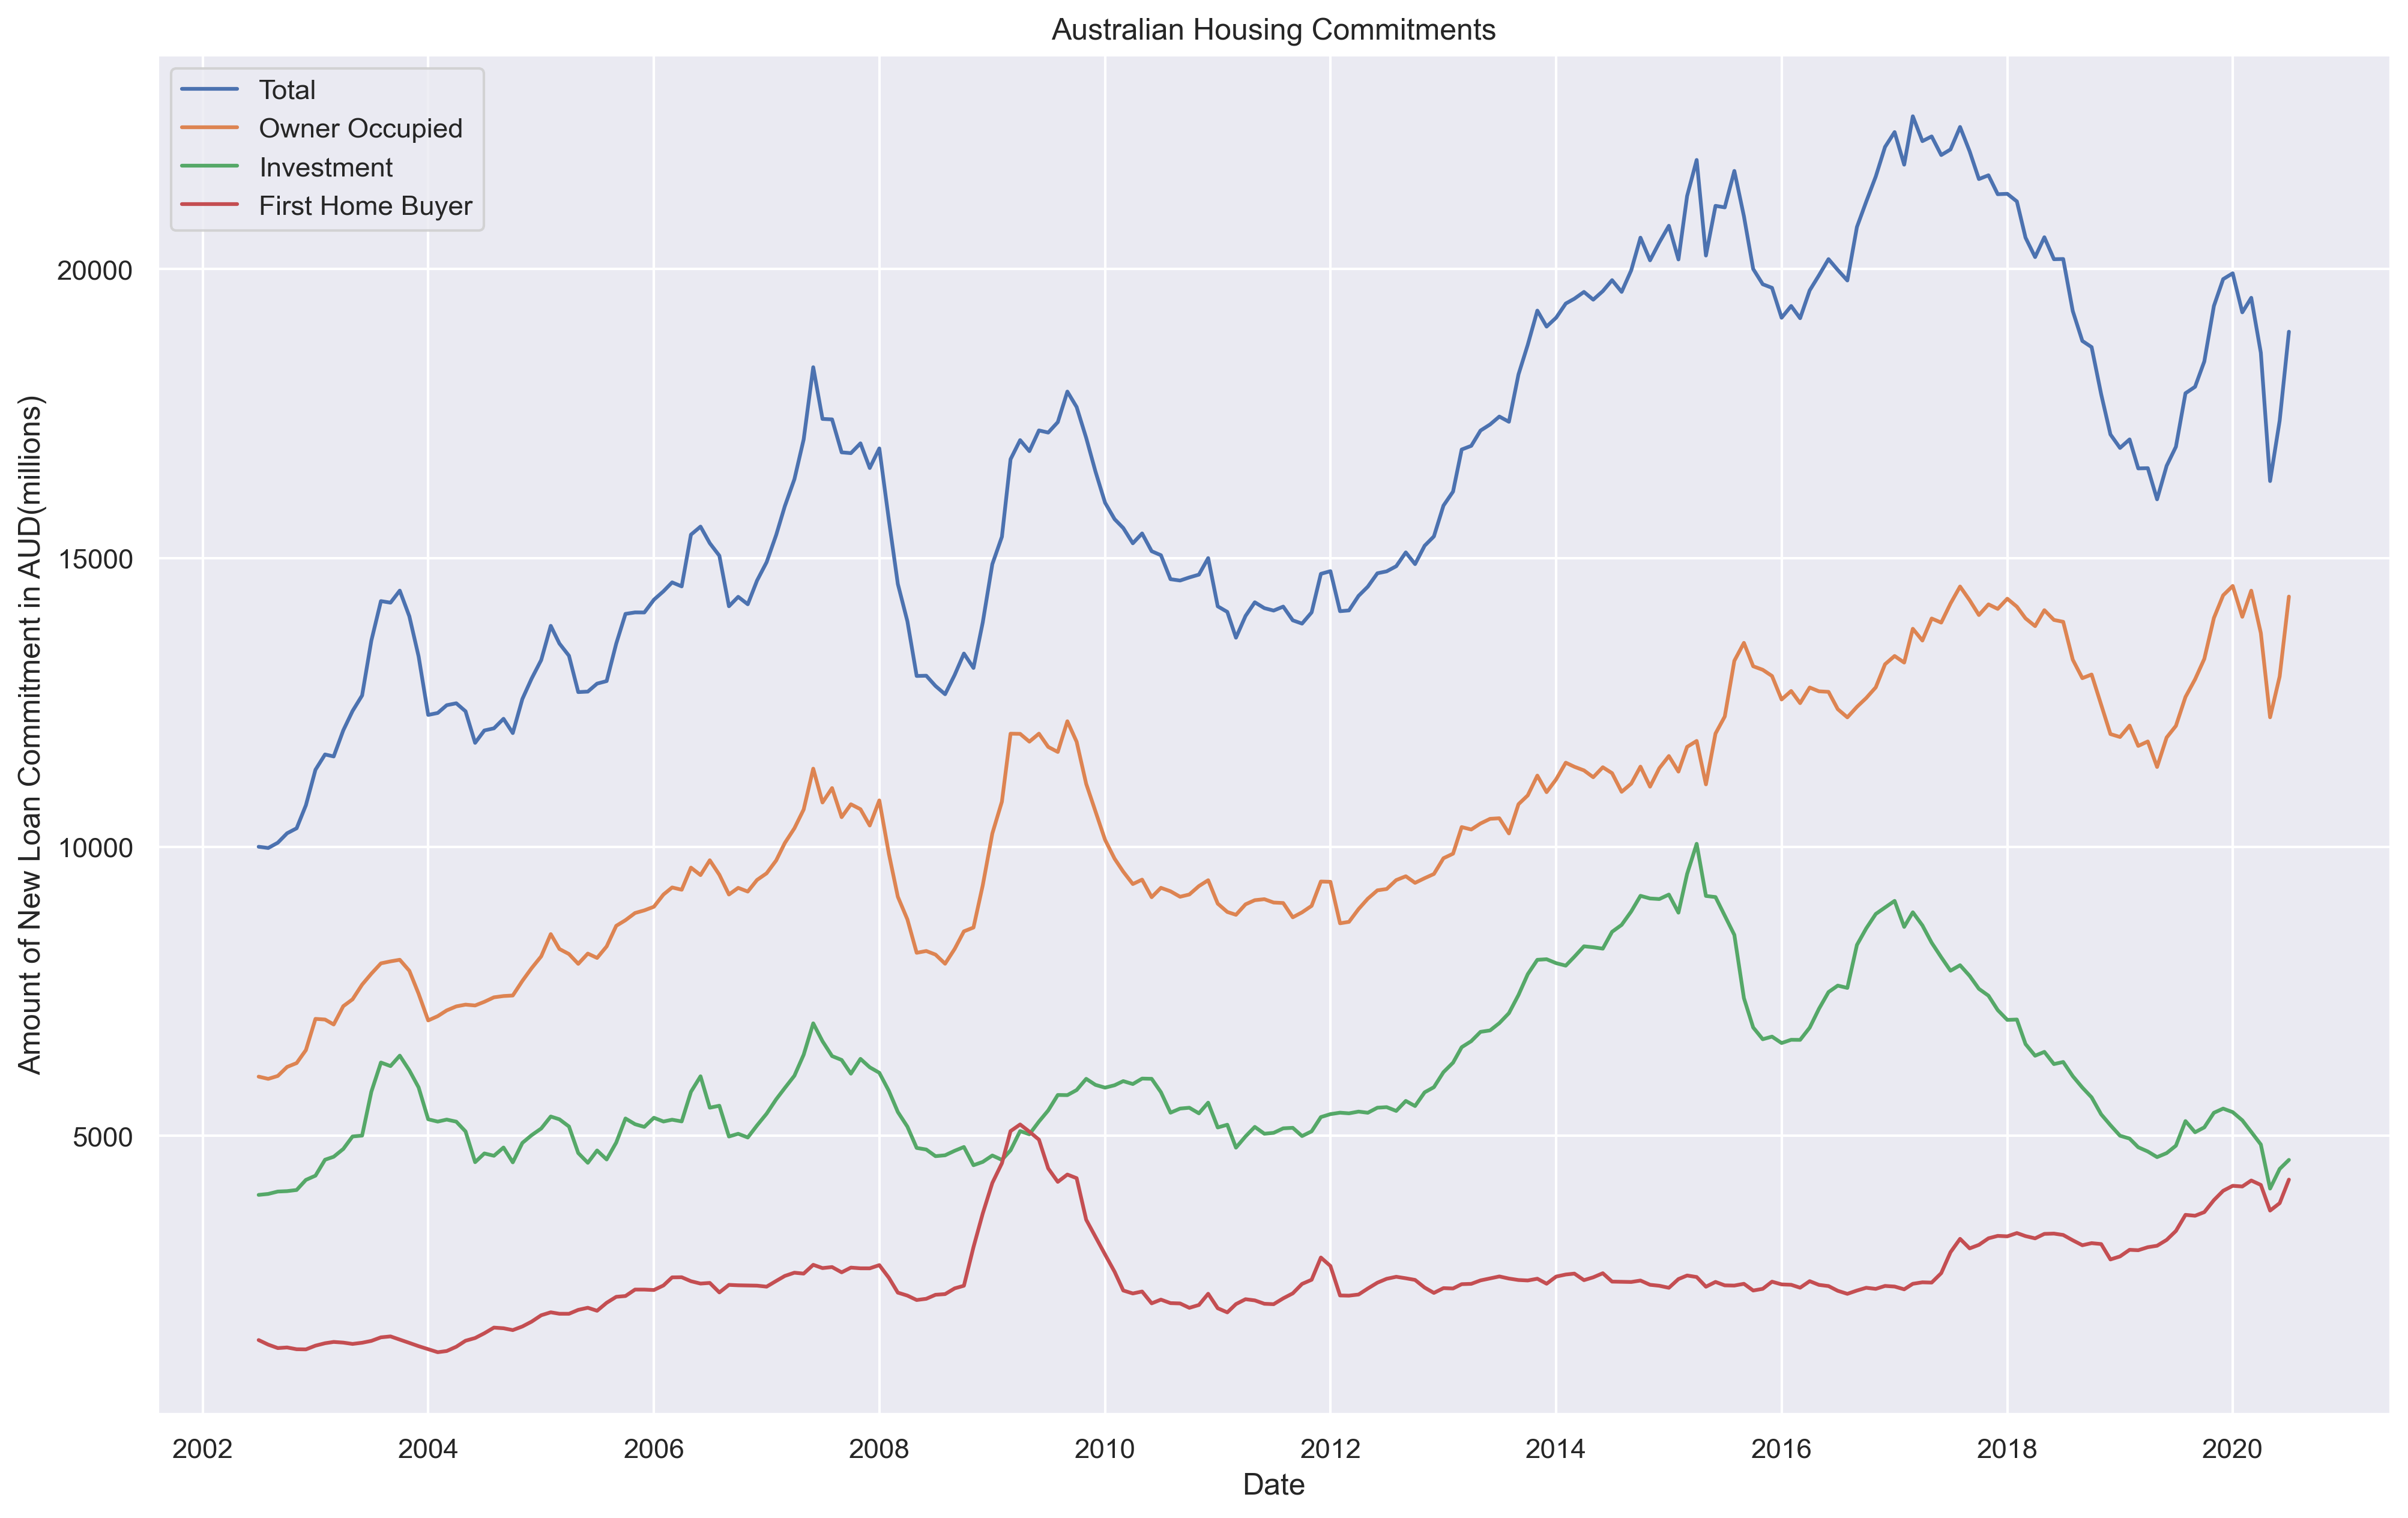

In [64]:
total = house_commitment['Total Commitment Value of Properties Purchased'].tolist()
oo = house_commitment['Commitment Value of Owner Occupied Properties Purchased'].tolist()
inv = house_commitment['Commitment Value of Investment Properties Purchased'].tolist()
fhb = house_commitment['Commitment Value from First Home Buyer'].tolist()
month = house_commitment['Date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

#(gdp 2002 - 2019, plt)
plt.plot(month, total, label = "Total")
plt.plot(month, oo, label = "Owner Occupied")
plt.plot(month, inv, label = "Investment")
plt.plot(month, fhb, label = "First Home Buyer")
plt.legend(loc="upper left")
plt.title('Australian Housing Commitments')
plt.xlabel('Date')
plt.ylabel('Amount of New Loan Commitment in AUD(millions)')
plt.show()

In [65]:
### Generate dataset from MySQL Server and rename as `asx200_month`
mydb = connect_mysql(host, id, pwd, db)
asx200_month = pd.read_sql_query("SELECT * FROM asx200_month", con=mydb)

# Convert data type of 'date' column to date.
asx200_month['date'] = pd.to_datetime(asx200_month['date'], format = '%Y-%m-%d')
asx200_month.head()
asx200_month.tail()

,date,open,high,low,close,adj_close,volume
331,2020-07-01,5897.899902,6160.600098,5892.799805,5927.799805,5927.799805,14681000.0
332,2020-08-01,5927.799805,6199.200195,5860.700195,6060.500000,6060.500000,15518500.0
333,2020-09-01,6060.500000,6130.799805,5763.200195,5815.899902,5815.899902,17107600.0
334,2020-10-01,5815.899902,6127.399902,5779.600098,6102.200195,6102.200195,4271500.0
335,2020-10-12,6102.200195,6132.000000,6093.100098,6132.000000,6132.000000,0.0


In [66]:
# Briefly check dataset
asx200_month.info()
asx200_month.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       336 non-null    datetime64[ns]
 1   open       336 non-null    float64       
 2   high       336 non-null    float64       
 3   low        336 non-null    float64       
 4   close      336 non-null    float64       
 5   adj_close  336 non-null    float64       
 6   volume     336 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 18.5 KB


,open,high,low,close,adj_close,volume
count,336.000000,336.000000,336.000000,336.000000,336.000000,3.360000e+02
mean,4128.569052,4246.216075,4000.505061,4141.482150,4141.482150,6.585566e+08
std,1446.714250,1485.334997,1394.429983,1443.590212,1443.590212,2.728489e+09
min,1452.300049,1564.699951,1442.099976,1536.500000,1536.500000,0.000000e+00
25%,2938.525024,3023.124939,2870.999939,2955.424927,2955.424927,0.000000e+00
50%,4270.950195,4381.449951,4083.000000,4287.000000,4287.000000,0.000000e+00
75%,5395.024902,5526.150024,5161.574951,5397.975098,5397.975098,0.000000e+00
max,7017.200195,7197.200195,6669.200195,7017.200195,7017.200195,1.490900e+10


In [67]:
# Filter 'asx200_month' dataset with the same time period as 'gdp_per_cap' dataset
start_date = "1993-01-01"
end_date = "2019-01-01"
after_start_date = gdp_per_cap["Year"] >= start_date
before_end_date = gdp_per_cap["Year"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = gdp_per_cap. loc[between_two_dates]
filtered_dates.head()

,Year,GDP_per_cap,GDP_Growth_in_dollars
22,1993-01-01,17634.26,-935.55
23,1994-01-01,18046.02,411.76
24,1995-01-01,20319.63,2273.61
25,1996-01-01,21861.33,1541.70
26,1997-01-01,23468.60,1607.27


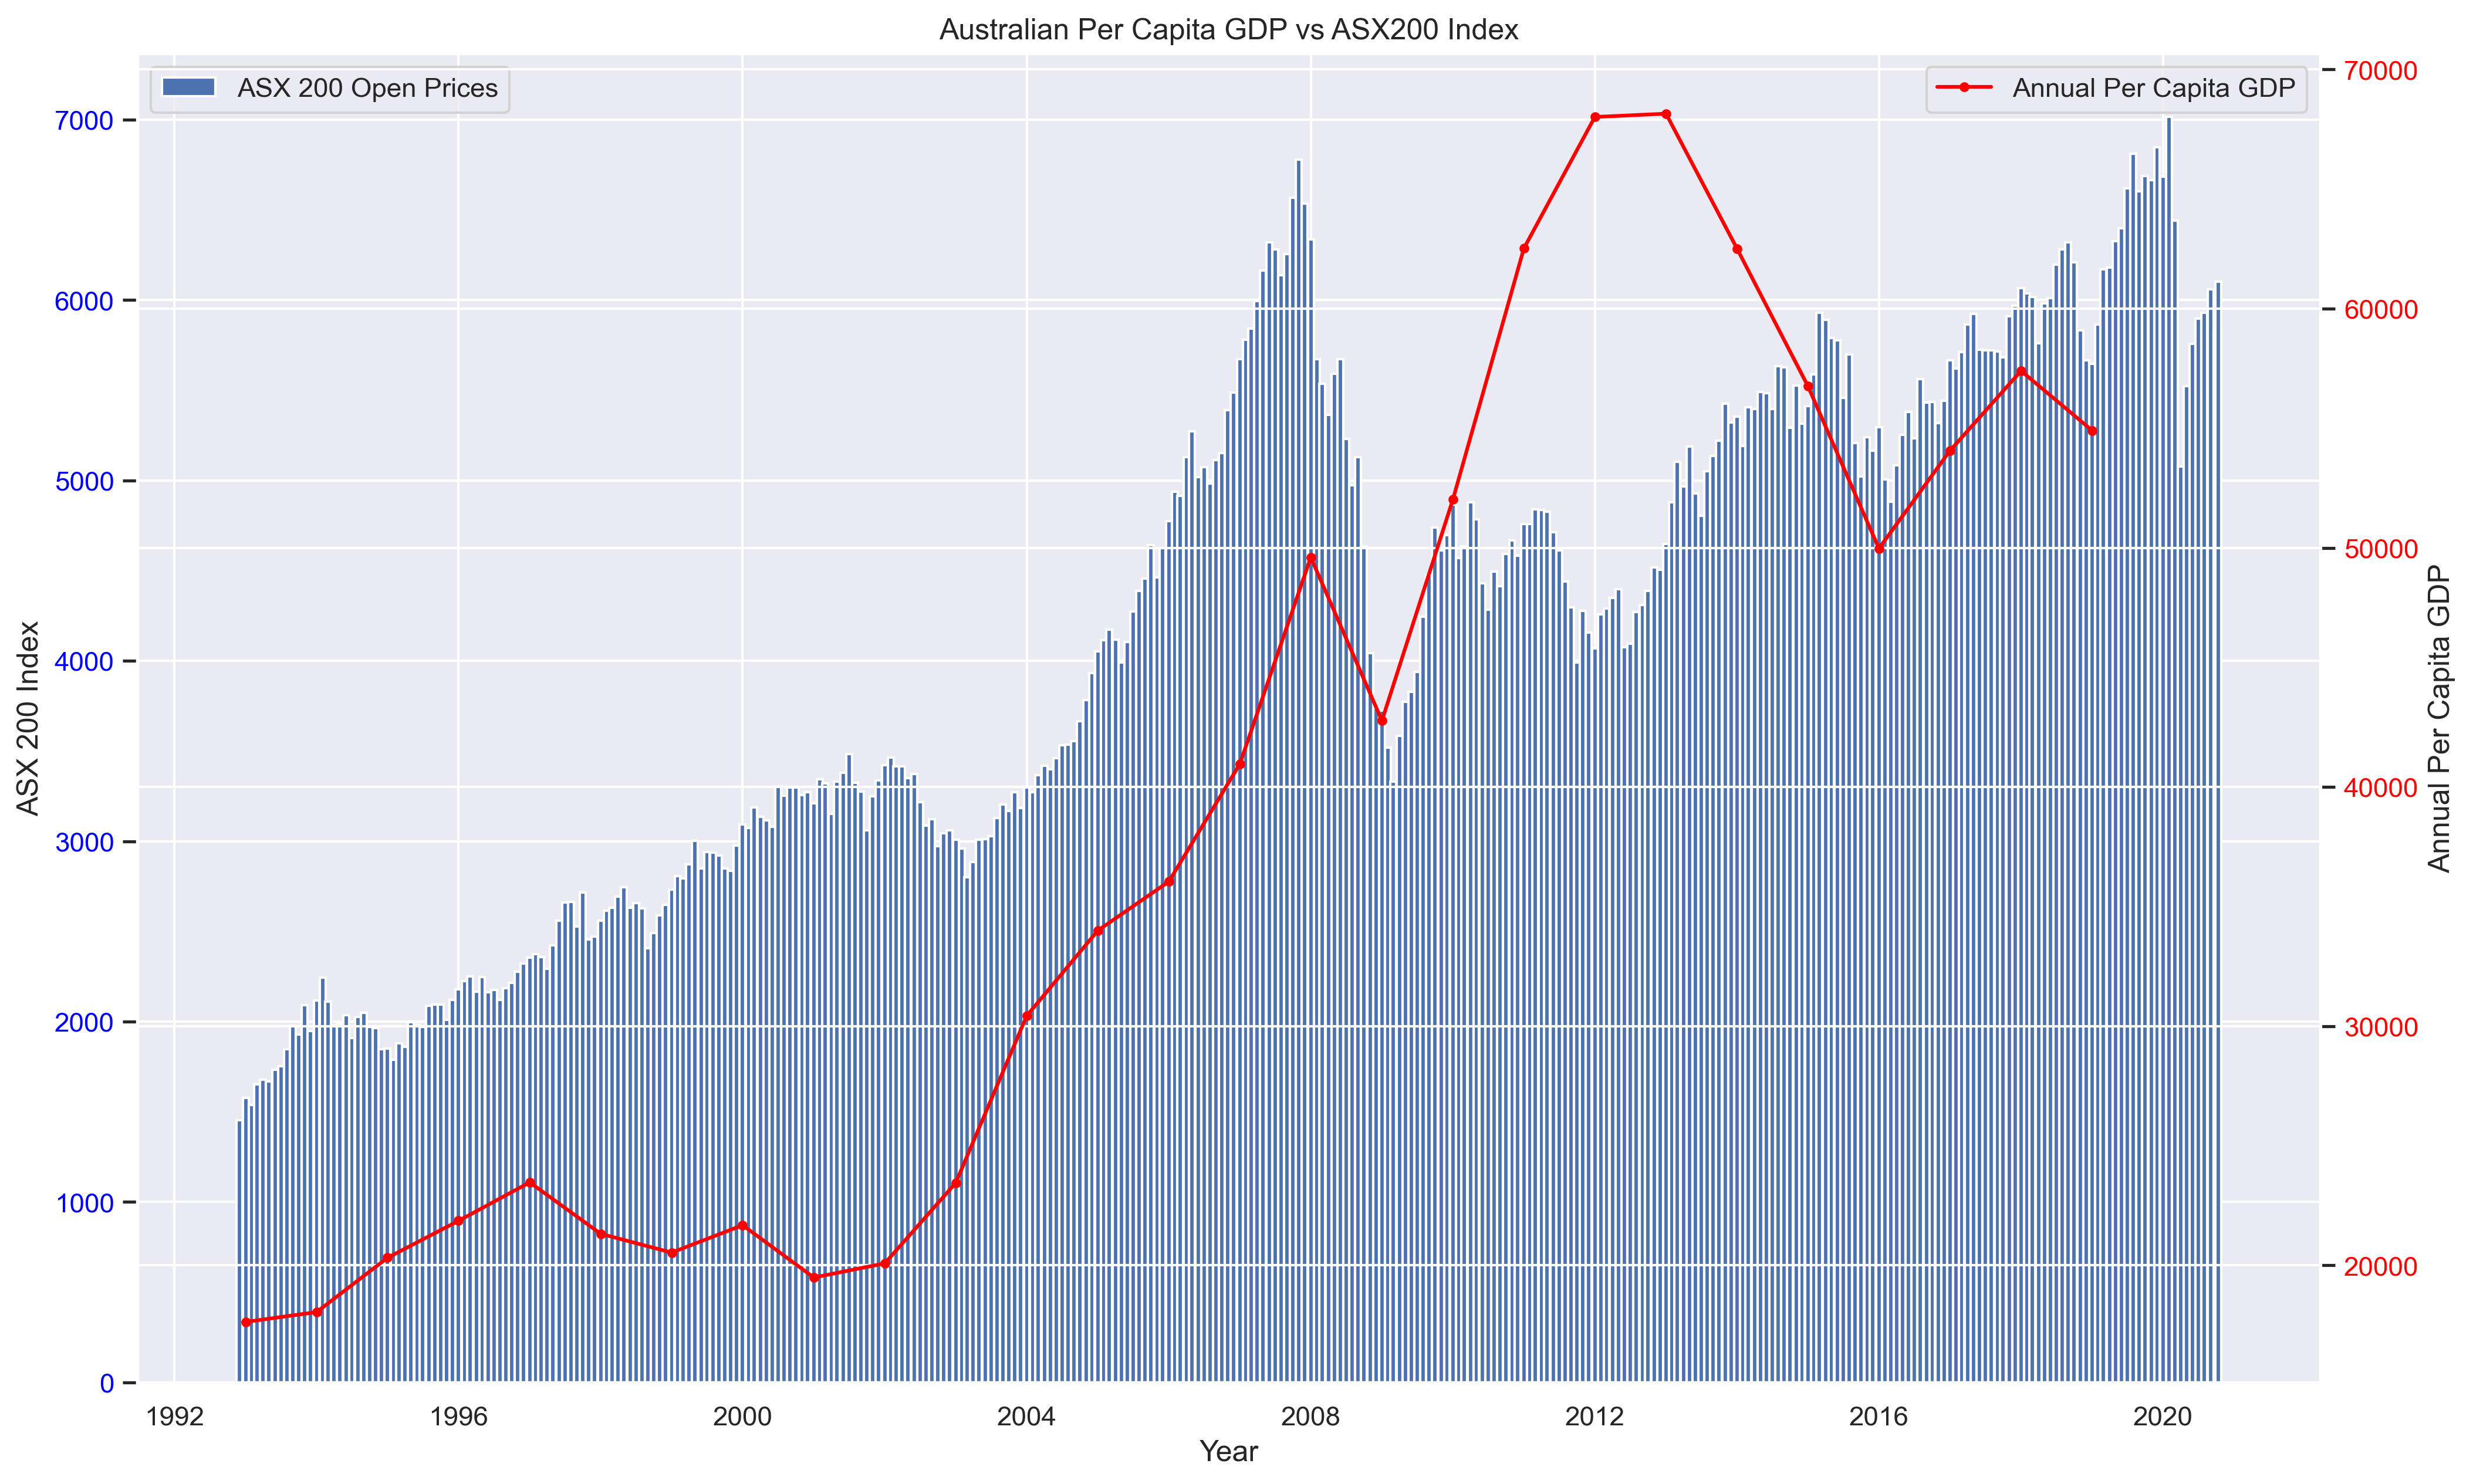

In [68]:
# Visualisation of Annual Per Capita GDP and ASX 200 Index Open Price
asx200_open = asx200_month['open'].tolist()
asx200_close = asx200_month['close'].tolist()
month = asx200_month['date'].tolist()
gdp = filtered_dates['GDP_per_cap'].tolist()
year = filtered_dates['Year'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index')
lns1 = axes1.bar(month, asx200_open, width=30, align = 'center', label = 'ASX 200 Open Prices')
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:red'
axes2.set_ylabel('Annual Per Capita GDP')
lns2 = axes2.plot(year, gdp, marker = ".", color = "red", label = "Annual Per Capita GDP")
axes1.tick_params(axis='y', labelcolor="blue")
axes2.tick_params(axis='y', labelcolor="red")
axes2.legend(loc = "upper right")

plt.title('Australian Per Capita GDP vs ASX200 Index')

plt.show()

In [69]:
# Filter 'asx200_month' dataset with the same time period as 'house_commitment' dataset
start_date = "2002-07-01"
end_date = "2020-07-01"
after_start_date = asx200_month["date"] >= start_date
before_end_date = asx200_month["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates_house = asx200_month.loc[between_two_dates]
filtered_dates_house.head()

,date,open,high,low,close,adj_close,volume
115,2002-07-01,3216.000000,3259.000000,2982.100098,3086.199951,3086.199951,0.0
116,2002-08-01,3086.199951,3202.899902,2955.699951,3120.100098,3120.100098,0.0
117,2002-09-01,3122.300049,3156.699951,2953.199951,2970.899902,2970.899902,0.0
118,2002-10-01,2970.899902,3043.000000,2883.500000,3042.899902,3042.899902,0.0
119,2002-11-01,3042.899902,3079.699951,2950.699951,3061.399902,3061.399902,0.0


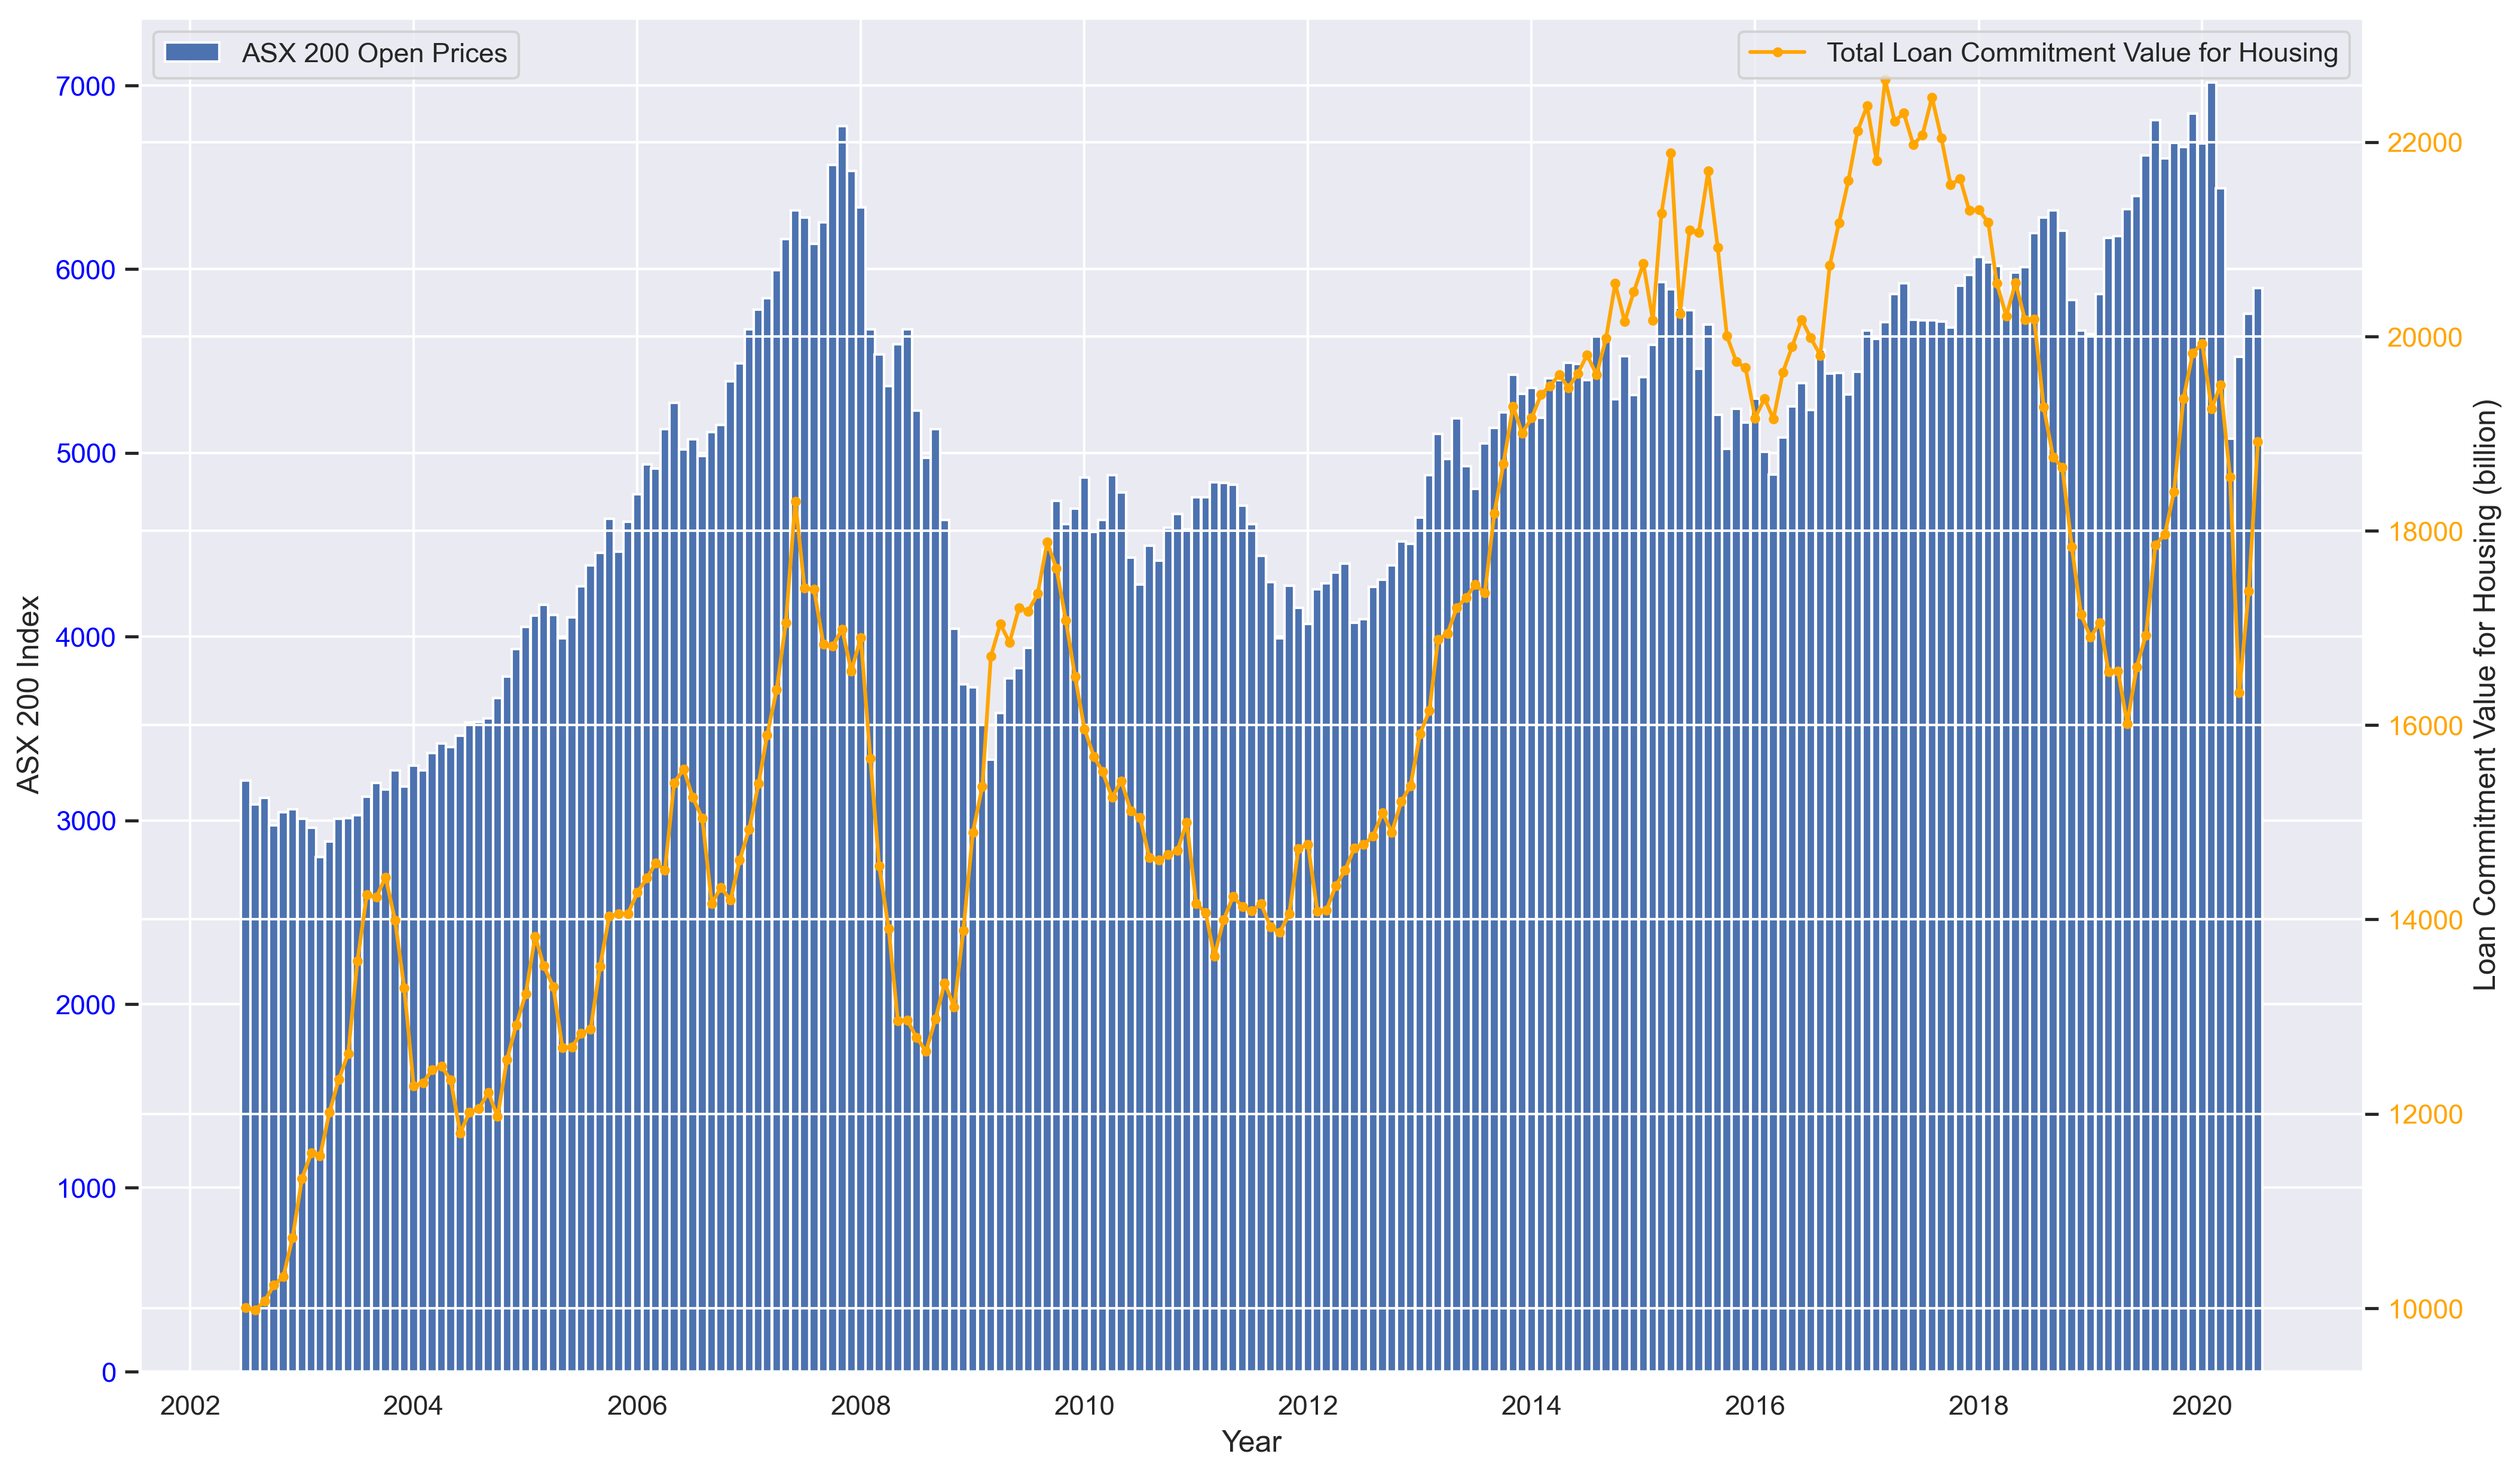

In [70]:
# Visualisation of Annual Per Capita GDP and Total New Loan Commitment Value for Housing
total = house_commitment['Total Commitment Value of Properties Purchased'].tolist()
asx200 = filtered_dates_house['open'].tolist()
month = house_commitment['Date'].tolist()
month_2 = filtered_dates_house['date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index')
lns1 = axes1.bar(month_2, asx200, width=30, align = 'center', label = 'ASX 200 Open Prices')
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:orange'
axes2.set_ylabel('Loan Commitment Value for Housing (billion)')
lns2 = axes2.plot(month, total, marker = ".", color = "orange", label = "Total Loan Commitment Value for Housing")
axes1.tick_params(axis='y', labelcolor="blue")
axes2.tick_params(axis='y', labelcolor="orange")
axes2.legend(loc = "upper right")

In [81]:
gdp_all = filtered_dates['GDP_per_cap'].tolist()
date_all = filtered_dates['Year'].tolist()
filtered_dates

,Year,GDP_per_cap,GDP_Growth_in_dollars
22,1993-01-01,17634.26,-935.55
23,1994-01-01,18046.02,411.76
24,1995-01-01,20319.63,2273.61
25,1996-01-01,21861.33,1541.70
26,1997-01-01,23468.60,1607.27
27,1998-01-01,21318.96,-2149.64
28,1999-01-01,20533.04,-785.92
29,2000-01-01,21679.25,1146.21
30,2001-01-01,19490.86,-2188.39
31,2002-01-01,20082.48,591.62


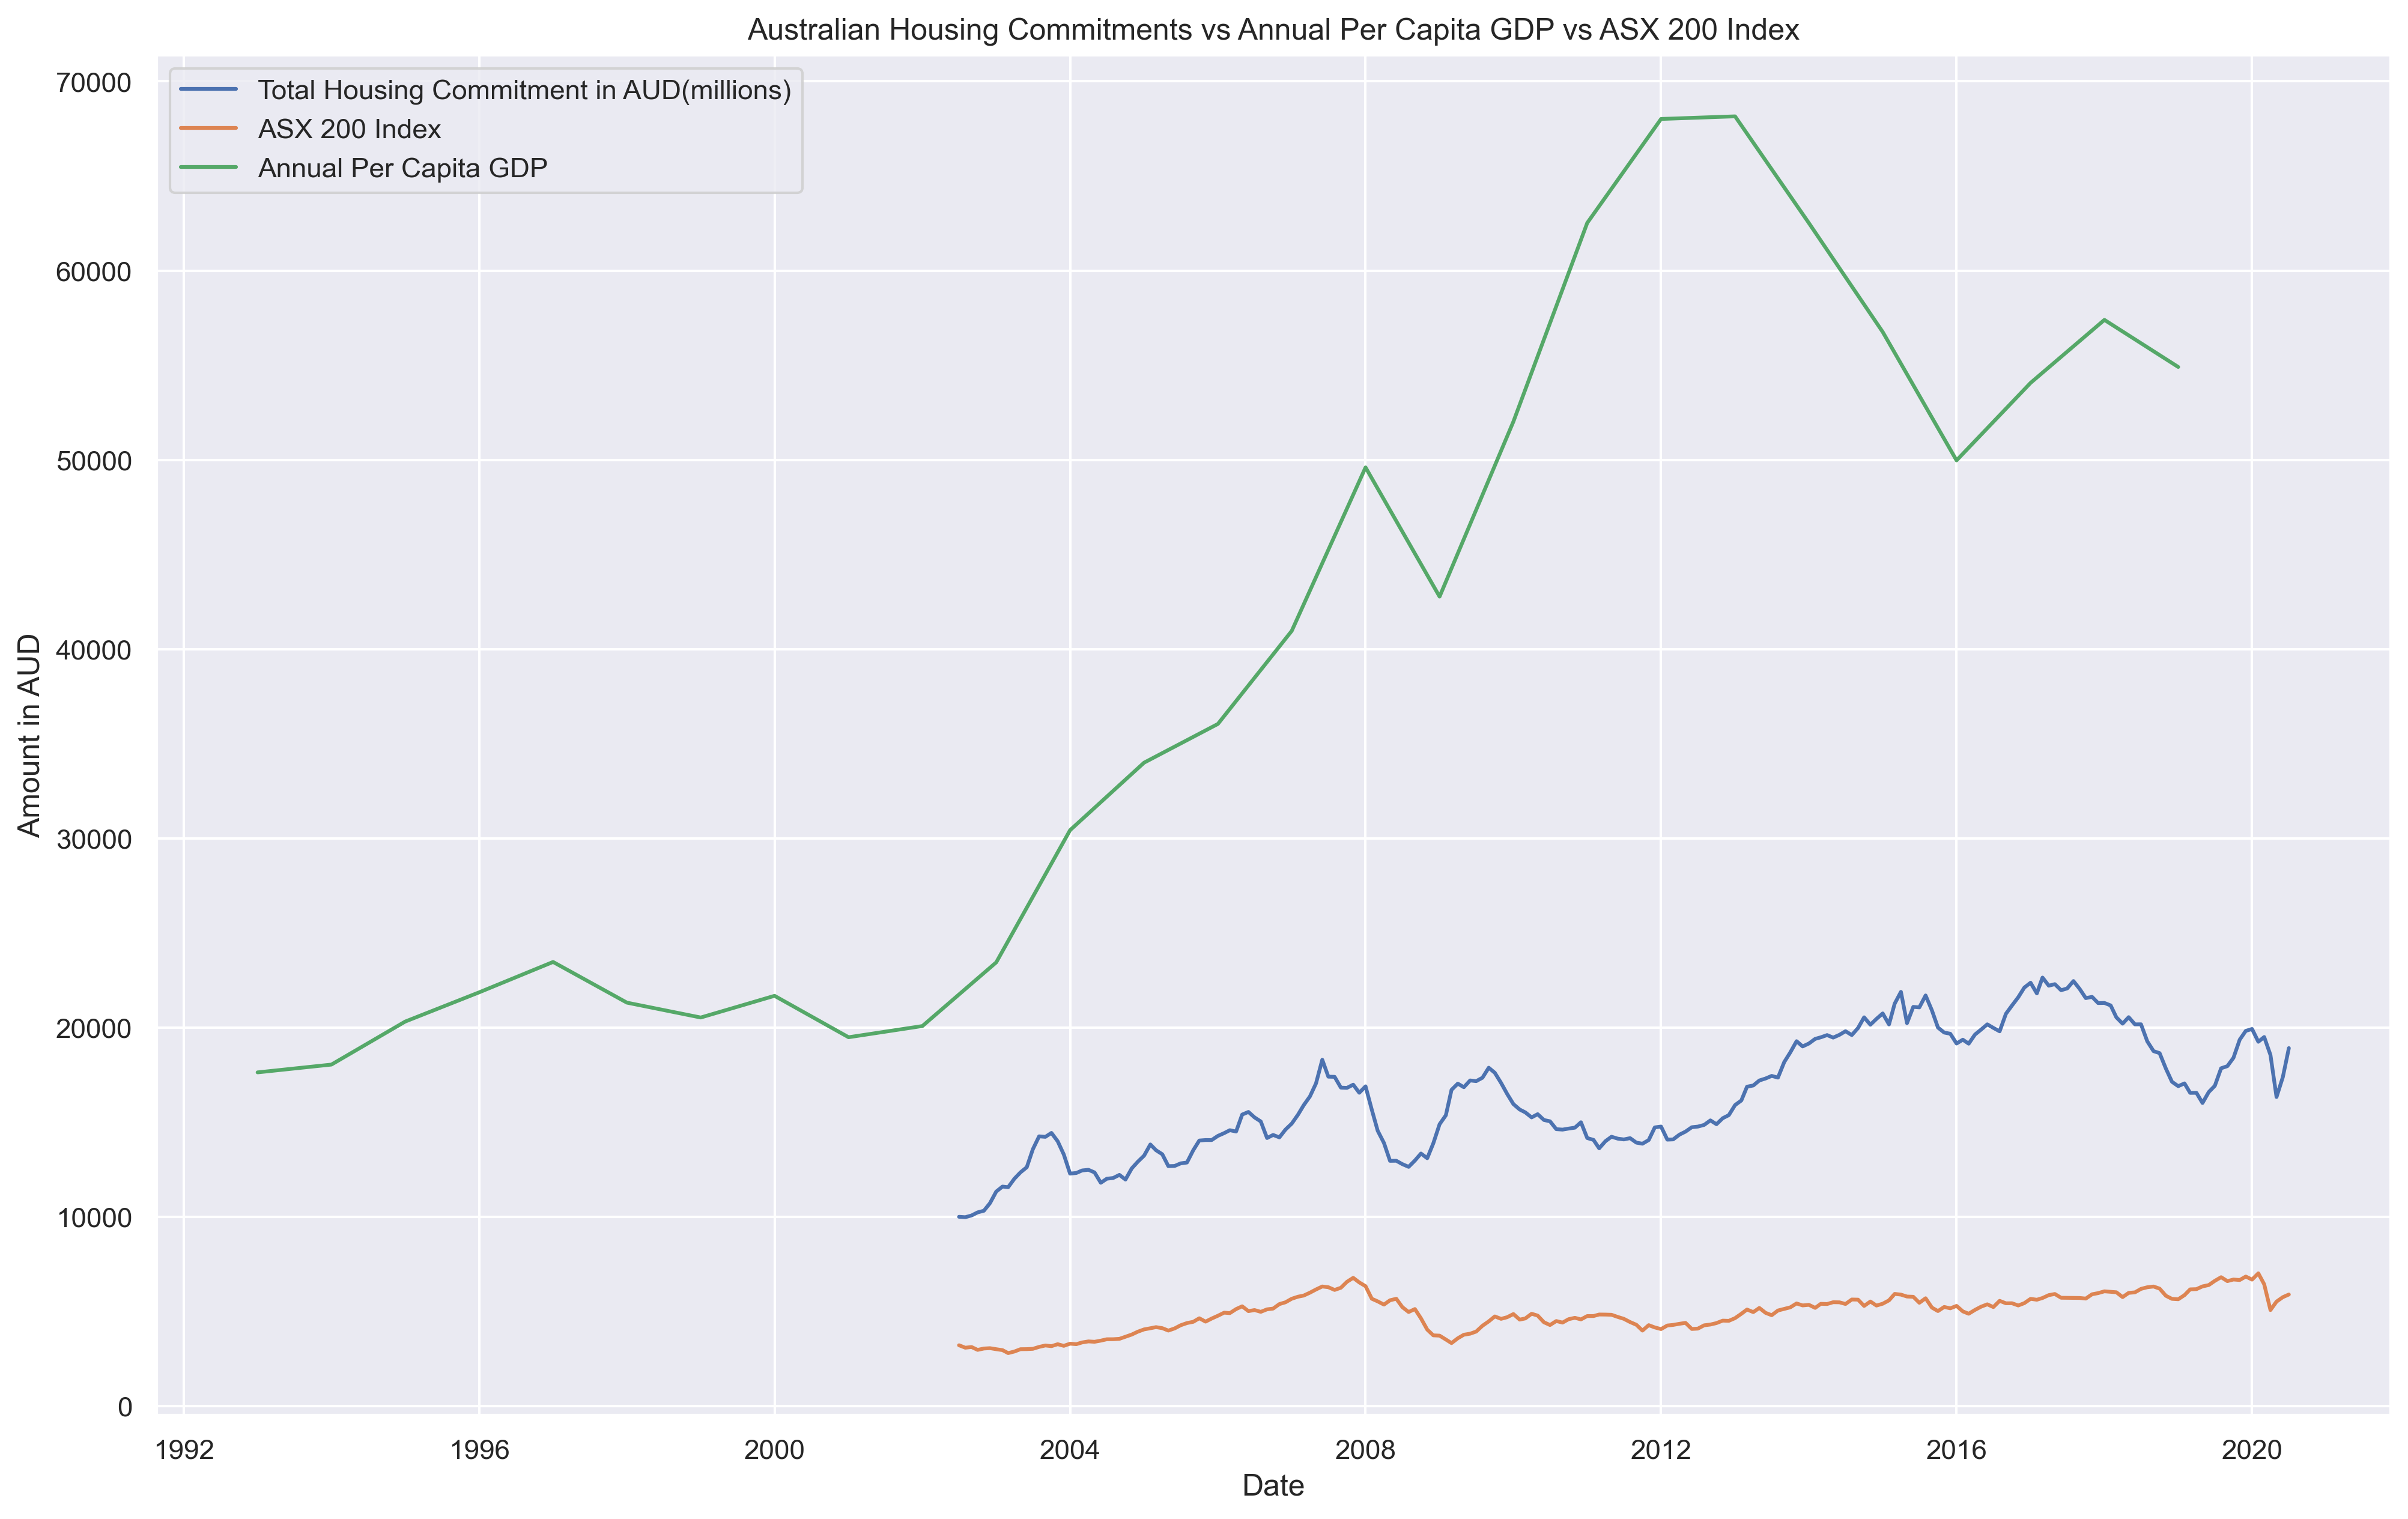

In [85]:
fig = plt.figure(figsize = (16,10), dpi = 300)
plt.plot(month_2, total, label = "Total Housing Commitment in AUD(millions)")
plt.plot(month_2, asx200, label = "ASX 200 Index")
plt.plot(date_all, gdp_all, label = "Annual Per Capita GDP")

plt.legend(loc="upper left")
plt.title('Australian Housing Commitments vs Annual Per Capita GDP vs ASX 200 Index')
plt.xlabel('Date')
plt.ylabel('Amount in AUD')
plt.show()

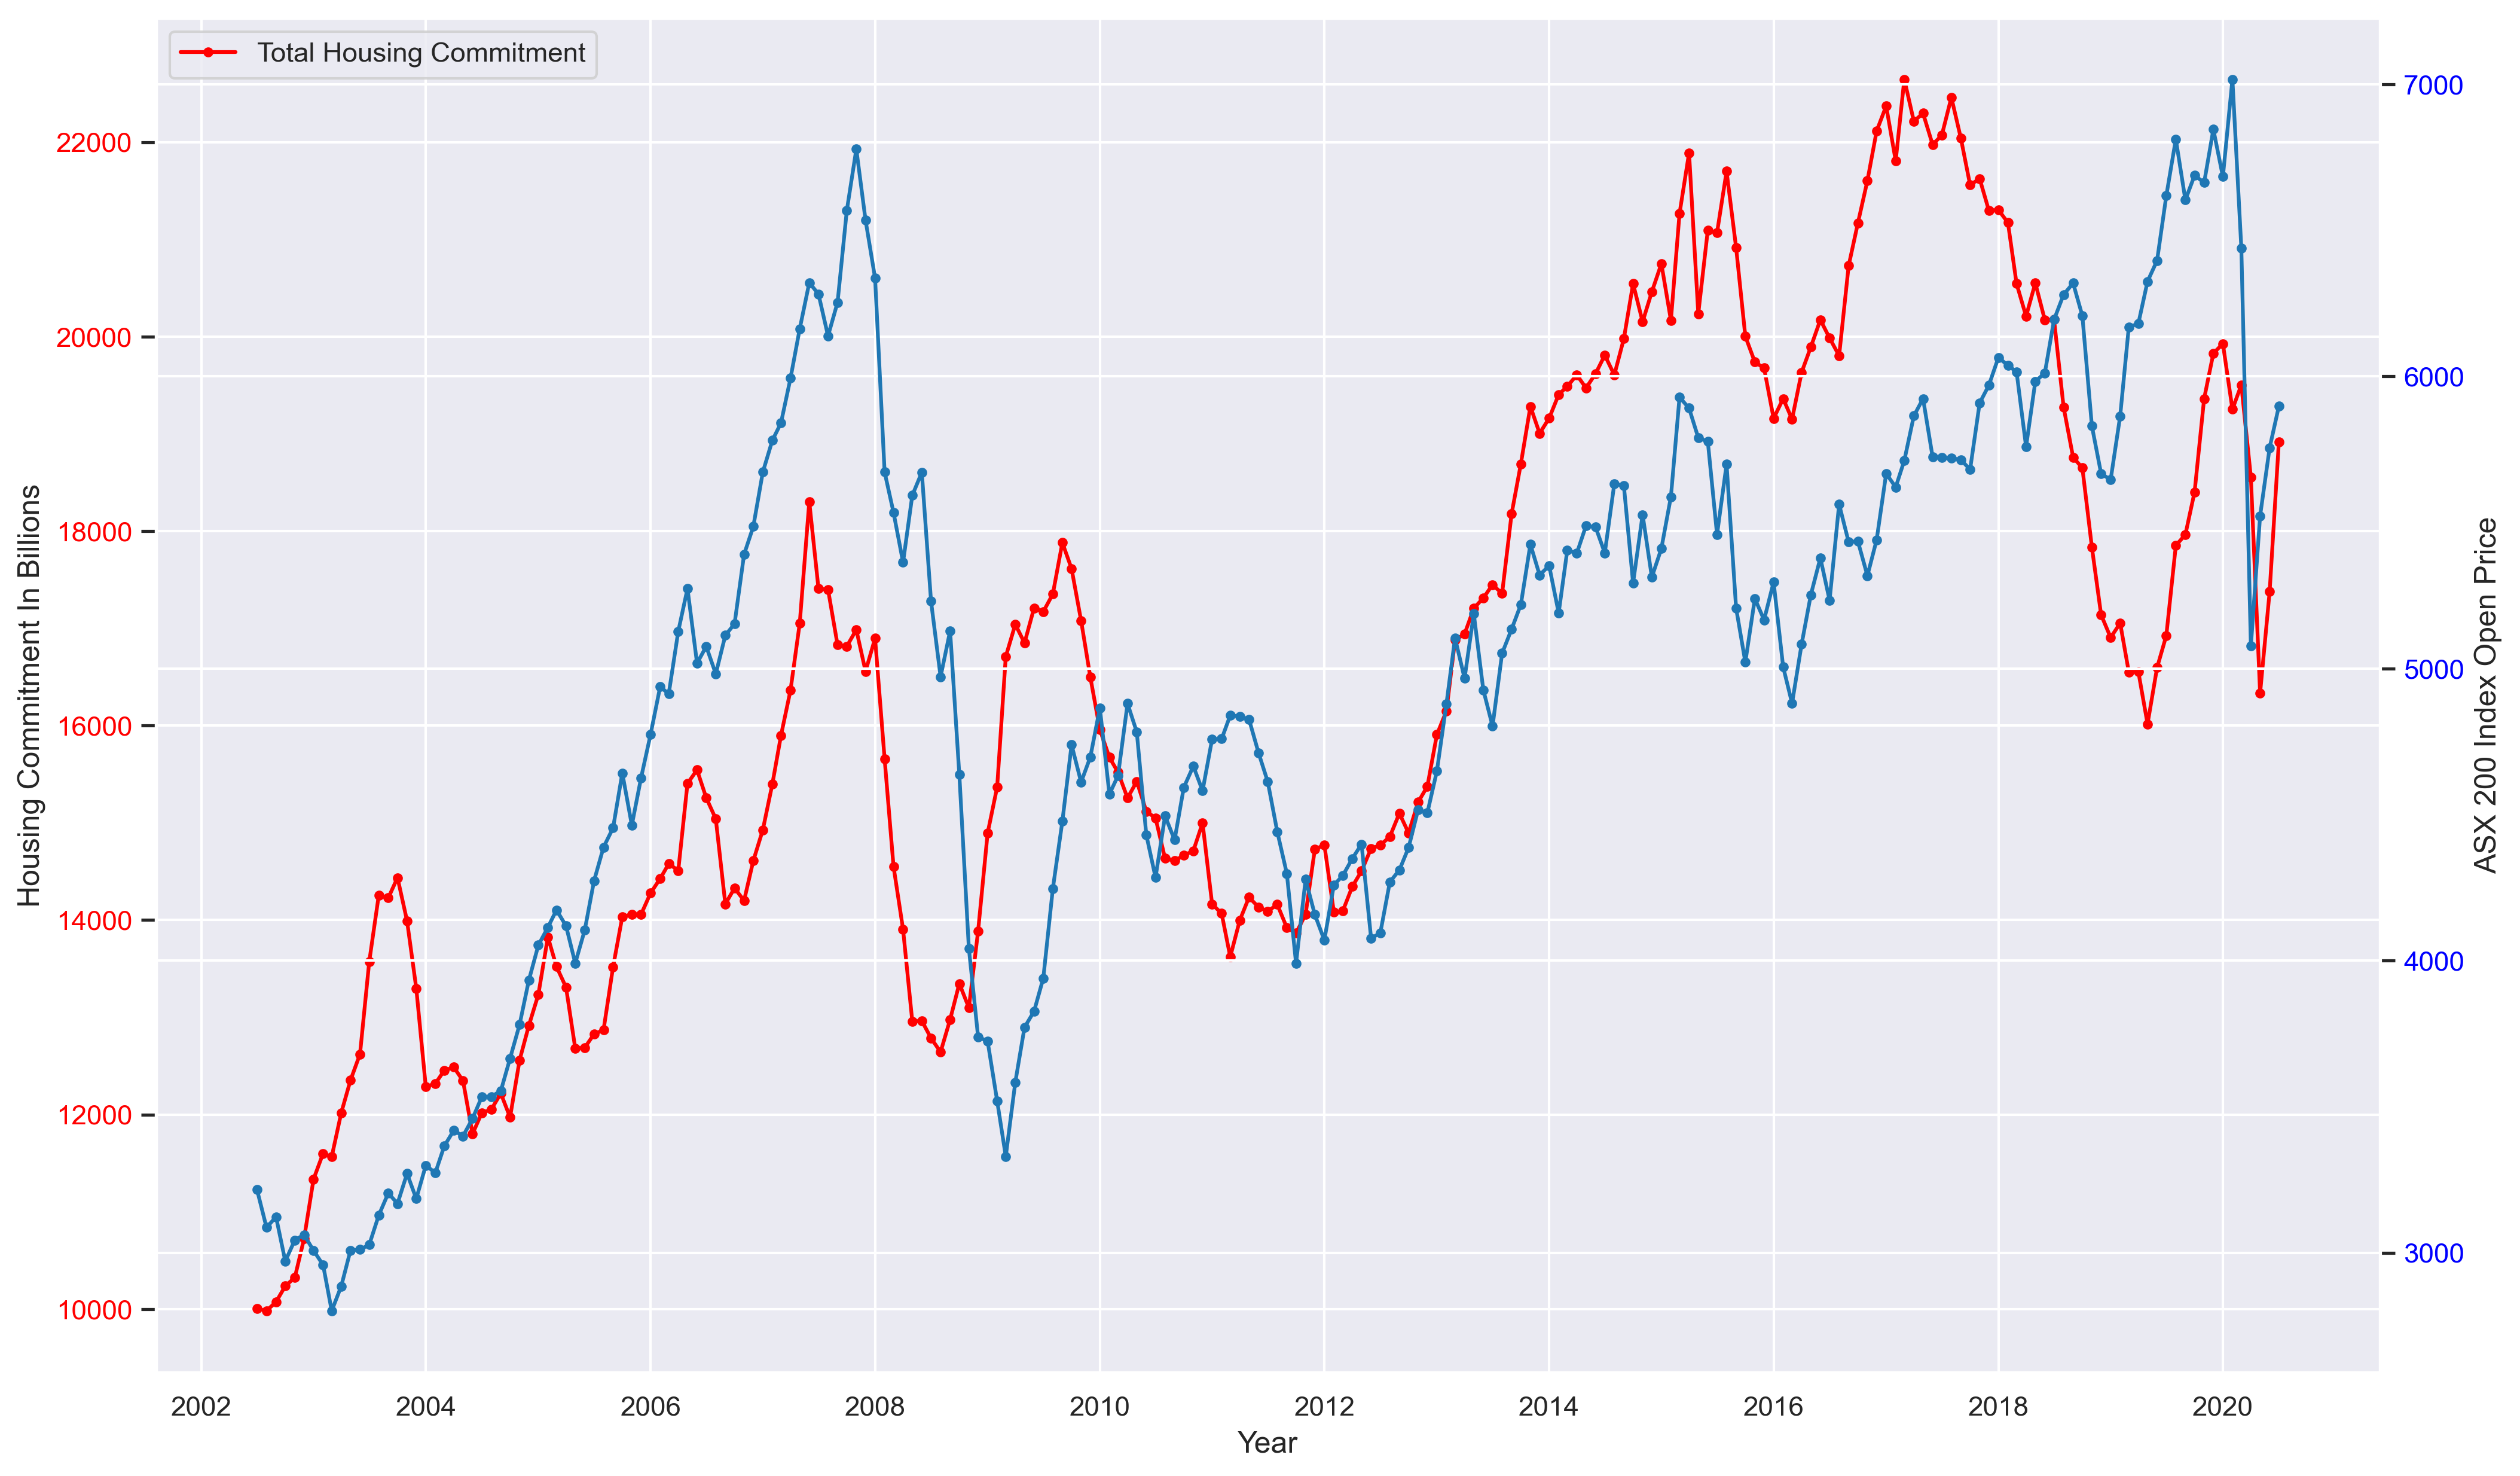

In [75]:
total = house_commitment['Total Commitment Value of Properties Purchased'].tolist()
asx200 = filtered_dates_house['open'].tolist()
month_2 = filtered_dates_house['date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('Housing Commitment In Billions')
lns1 = axes1.plot(month_2, total, marker = ".", color = "red", label = "Total Housing Commitment")
axes1.tick_params(axis='y', labelcolor="red")
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:blue'
axes2.set_ylabel('ASX 200 Index Open Price')
lns2 = axes2.plot(month_2, asx200, marker = ".", color = color, label = 'ASX 200 Index Open Price')
axes2.tick_params(axis='y', labelcolor="blue")

plt.show()